In [1]:
import time
start_time = time.time()

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import MultiTimeframeCandleManager
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

candles = obj_load("NQ_1")
len(candles)

loading NQ_1


99990

In [3]:

lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

#current_position = tf.keras.layers.Input(shape = (3,))

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(64)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(64)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(64)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(64)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(64)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(64)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(64)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(64)(m1_at)


#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, m1_at, m5_at])

d = tf.keras.layers.Dense(256)(c)
d = lrelu(d)
d = tf.keras.layers.Dense(256)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(256)(d)
d = lrelu(d)
d = tf.keras.layers.Dense(256)(d)
d = lrelu(d)


output = tf.keras.layers.Dense(1, activation="tanh")(d)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)



model.summary()


# In[10]:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 60, 94)       0           ['input_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 60, 98)       0           ['input_3[0][0]',                
                                                                  'lambda[0][0]']             

In [4]:
model.load_weights("model.weights.h5")

In [5]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = max(0.0001,(midnight_opening_range_high - midnight_opening_range_low) / 2)

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas[0:9+9+15]:
        pda_rel.append(relative(pda, center, r))
    for index in range(9+9+15,9+9+15+5*12):
        ## highs lows are like this [h, h_taken, l, l_taken]
        ## the bools should not be scaled
        if (index - 9+9+15) % 2 == 0:
            pda_rel.append(relative(pdas[index], center, r))
        else:
            pda_rel.append(pdas[index])

    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]


# In[11]:


class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction


In [6]:

t = 0.1

def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    #tf.expand_dims(pos_info, 0)
                )

                last_action = 0
                if output[0] > t:
                    last_action = 1
                if output[0] < -t:
                    last_action = -1
                    
                outputs.append(output[0])
            else:
                last_action = 0


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])

            if(last_action == 0 and current_position.direction != 0):
                equity += open_profit
                current_position = Position(0,0,0,0)
                #print("close position:", open_profit)

            if(last_action == -1 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == -1 and current_position.direction == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    tp = entry  -  avg_candle_range * tpm


                    current_order = Order(entry, sl, tp, -1)
                    #print("set short order:",entry,sl,tp)



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1 and current_position.direction == 0):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    tp = entry  +  avg_candle_range * tpm

                    current_order = Order(entry, sl, tp, 1)
                    #print("set long order:",entry,sl,tp)



In [7]:
m = MultiTimeframeCandleManager()

slm = 3
tpm = 6

current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes
    ])



#for index in tqdm(range(len(candles))):
for index in tqdm(range(100000)):
    step(index)
    if( index % 100 == 0 ):
        print(equity_L[-1])

print(equity_L[-1])

  2%|█▌                                                                       | 2151/100000 [00:00<00:04, 21299.73it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


  4%|███▏                                                                     | 4281/100000 [00:00<00:05, 18159.67it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.0
0.0
0.0
12.0
-7.987499999999272
-7.987499999999272
-7.987499999999272
-7.987499999999272
-7.987499999999272
-7.987499999999272
-7.987499999999272
-7.987499999999272
-7.987499999999272
-7.987499999999272


  6%|████▌                                                                      | 6113/100000 [00:20<07:10, 217.86it/s]

-7.987499999999272
-7.987499999999272
-7.987499999999272
-7.987499999999272
-1.0
1.7000000000007276
17.450000000000728
15.450000000000728
24.924999999999272
144.47499999999854
223.3249999999971


  7%|█████▎                                                                     | 7128/100000 [00:32<10:39, 145.17it/s]

208.8249999999971
290.3999999999978
270.1499999999978
275.3999999999978
285.8999999999978
279.1499999999978


  8%|█████▊                                                                     | 7741/100000 [00:39<12:35, 122.09it/s]

307.6499999999978
286.3999999999978
292.6499999999978
232.52499999999782


  8%|██████                                                                     | 8136/100000 [00:43<13:51, 110.45it/s]

256.7124999999978
236.02499999999782


  8%|██████▎                                                                    | 8400/100000 [00:47<14:35, 104.57it/s]

246.625
259.625


  9%|██████▍                                                                    | 8580/100000 [00:49<15:05, 100.91it/s]

280.09999999999854


  9%|██████▌                                                                     | 8706/100000 [00:51<15:43, 96.77it/s]

241.31249999999636


  9%|██████▋                                                                     | 8795/100000 [00:52<15:55, 95.45it/s]

282.0874999999978


  9%|██████▊                                                                     | 8906/100000 [00:53<16:23, 92.66it/s]

261.9375


  9%|██████▊                                                                     | 9009/100000 [00:54<17:19, 87.51it/s]

242.03749999999854


  9%|██████▉                                                                     | 9116/100000 [00:56<18:27, 82.07it/s]

272.2374999999993


  9%|███████                                                                     | 9215/100000 [00:57<18:50, 80.31it/s]

263.0625


  9%|███████                                                                     | 9310/100000 [00:58<18:46, 80.49it/s]

284.3500000000022


  9%|███████▏                                                                    | 9412/100000 [00:59<19:19, 78.11it/s]

262.8624999999993


 10%|███████▏                                                                    | 9508/100000 [01:01<21:30, 70.12it/s]

256.4249999999993


 10%|███████▎                                                                    | 9612/100000 [01:02<20:41, 72.82it/s]

271.5750000000007


 10%|███████▍                                                                    | 9708/100000 [01:03<21:12, 70.96it/s]

216.53750000000218


 10%|███████▍                                                                    | 9812/100000 [01:05<20:56, 71.78it/s]

216.53750000000218


 10%|███████▌                                                                    | 9915/100000 [01:06<21:09, 70.97it/s]

216.53750000000218


 10%|███████▌                                                                   | 10013/100000 [01:08<19:07, 78.43it/s]

209.28750000000218


 10%|███████▌                                                                   | 10111/100000 [01:09<18:54, 79.22it/s]

174.81250000000364


 10%|███████▋                                                                   | 10214/100000 [01:10<18:42, 80.00it/s]

146.0500000000029


 10%|███████▋                                                                   | 10312/100000 [01:11<19:09, 78.03it/s]

165.10000000000218


 10%|███████▊                                                                   | 10411/100000 [01:13<19:05, 78.18it/s]

161.32500000000073


 11%|███████▉                                                                   | 10508/100000 [01:14<18:46, 79.46it/s]

148.20000000000073


 11%|███████▉                                                                   | 10611/100000 [01:15<18:02, 82.55it/s]

148.20000000000073


 11%|████████                                                                   | 10712/100000 [01:17<18:53, 78.78it/s]

148.20000000000073


 11%|████████                                                                   | 10813/100000 [01:18<18:23, 80.81it/s]

148.20000000000073


 11%|████████▏                                                                  | 10908/100000 [01:19<18:11, 81.60it/s]

148.20000000000073


 11%|████████▎                                                                  | 11017/100000 [01:21<17:54, 82.85it/s]

148.20000000000073


 11%|████████▎                                                                  | 11113/100000 [01:22<17:42, 83.68it/s]

148.20000000000073


 11%|████████▍                                                                  | 11209/100000 [01:23<17:57, 82.43it/s]

148.20000000000073


 11%|████████▍                                                                  | 11308/100000 [01:24<19:12, 76.95it/s]

148.20000000000073


 11%|████████▌                                                                  | 11411/100000 [01:26<17:11, 85.86it/s]

148.20000000000073


 12%|████████▋                                                                  | 11516/100000 [01:27<18:06, 81.43it/s]

148.20000000000073


 12%|████████▋                                                                  | 11614/100000 [01:28<19:11, 76.77it/s]

148.20000000000073


 12%|████████▊                                                                  | 11712/100000 [01:30<18:43, 78.59it/s]

148.20000000000073


 12%|████████▊                                                                  | 11810/100000 [01:31<19:01, 77.27it/s]

148.20000000000073


 12%|████████▉                                                                  | 11915/100000 [01:32<19:22, 75.78it/s]

148.20000000000073


 12%|█████████                                                                  | 12016/100000 [01:34<17:19, 84.65it/s]

148.20000000000073


 12%|█████████                                                                  | 12113/100000 [01:35<17:28, 83.80it/s]

148.20000000000073


 12%|█████████▏                                                                 | 12213/100000 [01:36<18:32, 78.89it/s]

148.20000000000073


 12%|█████████▏                                                                 | 12311/100000 [01:38<18:49, 77.63it/s]

148.20000000000073


 12%|█████████▎                                                                 | 12408/100000 [01:39<19:58, 73.09it/s]

148.20000000000073


 13%|█████████▍                                                                 | 12514/100000 [01:40<19:28, 74.89it/s]

148.20000000000073


 13%|█████████▍                                                                 | 12616/100000 [01:42<17:36, 82.69it/s]

148.20000000000073


 13%|█████████▌                                                                 | 12711/100000 [01:43<17:21, 83.82it/s]

148.20000000000073


 13%|█████████▌                                                                 | 12814/100000 [01:44<18:27, 78.69it/s]

148.20000000000073


 13%|█████████▋                                                                 | 12912/100000 [01:46<19:07, 75.93it/s]

148.20000000000073


 13%|█████████▊                                                                 | 13010/100000 [01:47<18:32, 78.19it/s]

148.20000000000073


 13%|█████████▊                                                                 | 13112/100000 [01:48<17:28, 82.85it/s]

148.20000000000073


 13%|█████████▉                                                                 | 13207/100000 [01:49<17:47, 81.32it/s]

148.20000000000073


 13%|█████████▉                                                                 | 13309/100000 [01:51<18:18, 78.94it/s]

148.20000000000073


 13%|██████████                                                                 | 13415/100000 [01:52<19:07, 75.47it/s]

148.20000000000073


 14%|██████████▏                                                                | 13515/100000 [01:53<18:03, 79.81it/s]

148.20000000000073


 14%|██████████▏                                                                | 13608/100000 [01:55<17:26, 82.58it/s]

148.20000000000073


 14%|██████████▎                                                                | 13709/100000 [01:56<18:09, 79.18it/s]

148.20000000000073


 14%|██████████▎                                                                | 13812/100000 [01:57<16:35, 86.62it/s]

148.20000000000073


 14%|██████████▍                                                                | 13907/100000 [01:58<17:37, 81.42it/s]

148.20000000000073


 14%|██████████▌                                                                | 14009/100000 [02:00<17:52, 80.17it/s]

148.20000000000073


 14%|██████████▌                                                                | 14114/100000 [02:01<16:36, 86.20it/s]

148.20000000000073


 14%|██████████▋                                                                | 14213/100000 [02:02<16:21, 87.44it/s]

148.20000000000073


 14%|██████████▋                                                                | 14311/100000 [02:03<16:50, 84.82it/s]

136.1875


 14%|██████████▊                                                                | 14418/100000 [02:05<16:32, 86.19it/s]

81.26250000000073


 15%|██████████▉                                                                | 14518/100000 [02:06<16:16, 87.54it/s]

86.26250000000073


 15%|██████████▉                                                                | 14615/100000 [02:07<17:15, 82.43it/s]

97.76250000000073


 15%|███████████                                                                | 14713/100000 [02:09<18:16, 77.77it/s]

80.48749999999927


 15%|███████████                                                                | 14812/100000 [02:10<17:32, 80.94it/s]

30.887500000000728


 15%|███████████▏                                                               | 14914/100000 [02:11<18:17, 77.53it/s]

19.887500000000728


 15%|███████████▎                                                               | 15014/100000 [02:13<17:49, 79.49it/s]

42.79999999999927


 15%|███████████▎                                                               | 15114/100000 [02:14<17:20, 81.60it/s]

-19.875


 15%|███████████▍                                                               | 15209/100000 [02:15<17:02, 82.94it/s]

-141.62499999999636


 15%|███████████▍                                                               | 15315/100000 [02:16<17:29, 80.71it/s]

-241.08749999999782


 15%|███████████▌                                                               | 15416/100000 [02:18<16:57, 83.11it/s]

-362.3374999999942


 16%|███████████▋                                                               | 15512/100000 [02:19<16:35, 84.84it/s]

-309.48749999999563


 16%|███████████▋                                                               | 15607/100000 [02:20<17:30, 80.33it/s]

-229.06249999999272


 16%|███████████▊                                                               | 15710/100000 [02:21<17:42, 79.31it/s]

-167.01249999999345


 16%|███████████▊                                                               | 15814/100000 [02:23<17:00, 82.46it/s]

-179.46249999999418


 16%|███████████▉                                                               | 15917/100000 [02:24<17:09, 81.64it/s]

-162.7874999999949


 16%|████████████                                                               | 16011/100000 [02:25<17:18, 80.90it/s]

-170.73749999999563


 16%|████████████                                                               | 16108/100000 [02:27<17:08, 81.60it/s]

-172.48749999999563


 16%|████████████▏                                                              | 16211/100000 [02:28<17:26, 80.10it/s]

-245.06249999999636


 16%|████████████▏                                                              | 16314/100000 [02:29<16:47, 83.10it/s]

-246.81249999999636


 16%|████████████▎                                                              | 16409/100000 [02:30<16:53, 82.45it/s]

-263.4624999999978


 17%|████████████▍                                                              | 16511/100000 [02:32<17:06, 81.30it/s]

-273.9624999999978


 17%|████████████▍                                                              | 16614/100000 [02:33<17:21, 80.08it/s]

-73.38749999999709


 17%|████████████▌                                                              | 16708/100000 [02:34<16:27, 84.38it/s]

-116.39999999999782


 17%|████████████▌                                                              | 16811/100000 [02:36<17:22, 79.83it/s]

-143.5124999999971


 17%|████████████▋                                                              | 16914/100000 [02:37<16:36, 83.34it/s]

-143.5124999999971


 17%|████████████▊                                                              | 17012/100000 [02:38<15:55, 86.89it/s]

-143.5124999999971


 17%|████████████▊                                                              | 17113/100000 [02:39<17:40, 78.18it/s]

-143.5124999999971


 17%|████████████▉                                                              | 17214/100000 [02:41<17:23, 79.36it/s]

-135.7624999999971


 17%|████████████▉                                                              | 17316/100000 [02:42<16:49, 81.90it/s]

-135.7624999999971


 17%|█████████████                                                              | 17411/100000 [02:43<16:39, 82.66it/s]

-135.7624999999971


 18%|█████████████▏                                                             | 17514/100000 [02:45<17:00, 80.80it/s]

-135.7624999999971


 18%|█████████████▏                                                             | 17616/100000 [02:46<16:42, 82.21it/s]

-115.76249999999709


 18%|█████████████▎                                                             | 17711/100000 [02:47<16:33, 82.79it/s]

-70.51249999999709


 18%|█████████████▎                                                             | 17812/100000 [02:48<17:00, 80.55it/s]

-177.4499999999971


 18%|█████████████▍                                                             | 17913/100000 [02:50<16:50, 81.24it/s]

-1.0499999999956344


 18%|█████████████▌                                                             | 18010/100000 [02:51<15:58, 85.55it/s]

98.07500000000437


 18%|█████████████▌                                                             | 18115/100000 [02:52<17:07, 79.72it/s]

193.0250000000051


 18%|█████████████▋                                                             | 18210/100000 [02:54<16:08, 84.43it/s]

197.5250000000051


 18%|█████████████▋                                                             | 18308/100000 [02:55<16:03, 84.75it/s]

184.0250000000051


 18%|█████████████▊                                                             | 18411/100000 [02:56<16:46, 81.05it/s]

184.0250000000051


 19%|█████████████▉                                                             | 18514/100000 [02:58<16:29, 82.37it/s]

184.0250000000051


 19%|█████████████▉                                                             | 18611/100000 [02:59<15:39, 86.66it/s]

184.0250000000051


 19%|██████████████                                                             | 18711/100000 [03:00<15:21, 88.19it/s]

184.0250000000051


 19%|██████████████                                                             | 18817/100000 [03:01<16:01, 84.43it/s]

184.0250000000051


 19%|██████████████▏                                                            | 18913/100000 [03:02<15:59, 84.54it/s]

184.0250000000051


 19%|██████████████▎                                                            | 19011/100000 [03:04<15:15, 88.44it/s]

184.0250000000051


 19%|██████████████▎                                                            | 19108/100000 [03:05<16:18, 82.69it/s]

184.0250000000051


 19%|██████████████▍                                                            | 19214/100000 [03:06<15:47, 85.30it/s]

184.0250000000051


 19%|██████████████▍                                                            | 19309/100000 [03:07<16:31, 81.37it/s]

231.7750000000051


 19%|██████████████▌                                                            | 19413/100000 [03:09<16:08, 83.18it/s]

275.62500000000364


 20%|██████████████▋                                                            | 19517/100000 [03:10<16:08, 83.09it/s]

168.26250000000073


 20%|██████████████▋                                                            | 19612/100000 [03:11<16:01, 83.63it/s]

271.96250000000146


 20%|██████████████▊                                                            | 19707/100000 [03:13<16:42, 80.09it/s]

262.2000000000007


 20%|██████████████▊                                                            | 19809/100000 [03:14<16:27, 81.19it/s]

147.0625


 20%|██████████████▉                                                            | 19914/100000 [03:15<15:44, 84.82it/s]

148.01250000000073


 20%|███████████████                                                            | 20009/100000 [03:16<16:32, 80.59it/s]

167.1125000000029


 20%|███████████████                                                            | 20112/100000 [03:18<16:18, 81.60it/s]

178.63750000000437


 20%|███████████████▏                                                           | 20210/100000 [03:19<15:40, 84.82it/s]

178.63750000000437


 20%|███████████████▏                                                           | 20315/100000 [03:20<15:52, 83.66it/s]

178.63750000000437


 20%|███████████████▎                                                           | 20410/100000 [03:21<16:37, 79.78it/s]

178.63750000000437


 21%|███████████████▍                                                           | 20512/100000 [03:23<15:54, 83.25it/s]

178.63750000000437


 21%|███████████████▍                                                           | 20614/100000 [03:24<16:21, 80.92it/s]

178.63750000000437


 21%|███████████████▌                                                           | 20717/100000 [03:25<16:01, 82.47it/s]

178.63750000000437


 21%|███████████████▌                                                           | 20814/100000 [03:27<15:18, 86.21it/s]

178.63750000000437


 21%|███████████████▋                                                           | 20909/100000 [03:28<16:23, 80.42it/s]

178.63750000000437


 21%|███████████████▊                                                           | 21012/100000 [03:29<15:38, 84.14it/s]

178.63750000000437


 21%|███████████████▊                                                           | 21110/100000 [03:30<16:06, 81.63it/s]

178.63750000000437


 21%|███████████████▉                                                           | 21219/100000 [03:32<14:43, 89.13it/s]

178.63750000000437


 21%|███████████████▉                                                           | 21308/100000 [03:33<15:37, 83.92it/s]

178.63750000000437


 21%|████████████████                                                           | 21416/100000 [03:34<17:07, 76.52it/s]

178.63750000000437


 22%|████████████████▏                                                          | 21508/100000 [03:36<16:13, 80.64it/s]

178.63750000000437


 22%|████████████████▏                                                          | 21612/100000 [03:37<15:43, 83.07it/s]

178.63750000000437


 22%|████████████████▎                                                          | 21714/100000 [03:38<16:28, 79.17it/s]

178.63750000000437


 22%|████████████████▎                                                          | 21807/100000 [03:39<16:13, 80.33it/s]

178.63750000000437


 22%|████████████████▍                                                          | 21910/100000 [03:41<15:55, 81.74it/s]

178.63750000000437


 22%|████████████████▌                                                          | 22015/100000 [03:42<15:11, 85.53it/s]

178.63750000000437


 22%|████████████████▌                                                          | 22112/100000 [03:43<15:06, 85.90it/s]

178.63750000000437


 22%|████████████████▋                                                          | 22213/100000 [03:45<16:22, 79.16it/s]

178.63750000000437


 22%|████████████████▋                                                          | 22307/100000 [03:46<15:55, 81.34it/s]

178.63750000000437


 22%|████████████████▊                                                          | 22415/100000 [03:47<14:37, 88.39it/s]

178.63750000000437


 23%|████████████████▉                                                          | 22511/100000 [03:48<15:49, 81.65it/s]

178.63750000000437


 23%|████████████████▉                                                          | 22612/100000 [03:50<16:09, 79.83it/s]

178.63750000000437


 23%|█████████████████                                                          | 22713/100000 [03:51<15:46, 81.67it/s]

178.63750000000437


 23%|█████████████████                                                          | 22817/100000 [03:52<15:16, 84.25it/s]

172.82500000000437


 23%|█████████████████▏                                                         | 22899/100000 [03:55<20:39, 62.18it/s]

164.0875000000051


 23%|█████████████████▎                                                         | 23013/100000 [04:00<36:07, 35.52it/s]

170.61250000000655


 23%|█████████████████▎                                                         | 23111/100000 [04:02<22:46, 56.28it/s]

178.887500000008


 23%|█████████████████▍                                                         | 23204/100000 [04:05<20:20, 62.93it/s]

167.262500000008


 23%|█████████████████▍                                                         | 23314/100000 [04:10<43:33, 29.34it/s]

179.1250000000109


 23%|█████████████████▌                                                         | 23408/100000 [04:13<25:22, 50.31it/s]

7.5750000000116415


 24%|█████████████████▋                                                         | 23500/100000 [04:16<22:41, 56.17it/s]

7.5750000000116415


 24%|█████████████████▋                                                         | 23615/100000 [04:21<38:48, 32.81it/s]

1.0750000000116415


 24%|█████████████████▊                                                         | 23709/100000 [04:24<24:03, 52.86it/s]

52.88750000001164


 24%|█████████████████▊                                                         | 23813/100000 [04:29<46:24, 27.36it/s]

28.125000000010914


 24%|█████████████████▉                                                         | 23913/100000 [04:32<23:34, 53.80it/s]

45.95000000001164


 24%|██████████████████                                                         | 24006/100000 [04:36<22:37, 55.99it/s]

112.32500000001164


 24%|██████████████████                                                         | 24108/100000 [04:42<49:51, 25.37it/s]

102.25000000001091


 24%|██████████████████▏                                                        | 24209/100000 [04:46<22:50, 55.30it/s]

89.48750000001019


 24%|█████████████████▋                                                       | 24307/100000 [04:52<1:32:09, 13.69it/s]

89.48750000001019


 24%|██████████████████▎                                                        | 24409/100000 [04:55<35:46, 35.22it/s]

89.48750000001019


 25%|██████████████████▍                                                        | 24507/100000 [04:59<21:32, 58.40it/s]

89.48750000001019


 25%|██████████████████▍                                                        | 24610/100000 [05:05<39:36, 31.72it/s]

89.48750000001019


 25%|██████████████████▌                                                        | 24706/100000 [05:08<25:28, 49.24it/s]

89.48750000001019


 25%|██████████████████                                                       | 24813/100000 [05:13<1:05:38, 19.09it/s]

89.48750000001019


 25%|██████████████████▋                                                        | 24911/100000 [05:17<29:20, 42.66it/s]

89.48750000001019


 25%|██████████████████▊                                                        | 25007/100000 [05:20<22:51, 54.70it/s]

89.48750000001019


 25%|██████████████████▊                                                        | 25107/100000 [05:26<41:16, 30.24it/s]

89.48750000001019


 25%|██████████████████▉                                                        | 25212/100000 [05:30<21:43, 57.36it/s]

89.48750000001019


 25%|██████████████████▉                                                        | 25309/100000 [05:35<49:09, 25.32it/s]

89.48750000001019


 25%|███████████████████                                                        | 25403/100000 [05:39<26:42, 46.56it/s]

72.15000000000873


 26%|███████████████████▏                                                       | 25510/100000 [05:44<52:57, 23.44it/s]

74.15000000000873


 26%|███████████████████▏                                                       | 25609/100000 [05:48<23:51, 51.96it/s]

74.15000000000873


 26%|███████████████████▎                                                       | 25710/100000 [05:53<47:07, 26.27it/s]

74.15000000000873


 26%|███████████████████▎                                                       | 25811/100000 [05:55<18:53, 65.46it/s]

74.15000000000873


 26%|███████████████████▍                                                       | 25905/100000 [05:56<20:57, 58.91it/s]

74.15000000000873


 26%|███████████████████▌                                                       | 26012/100000 [05:58<19:03, 64.69it/s]

74.15000000000873


 26%|███████████████████▌                                                       | 26112/100000 [06:00<18:31, 66.47it/s]

74.15000000000873


 26%|███████████████████▋                                                       | 26209/100000 [06:02<19:01, 64.66it/s]

9.462500000008731


 26%|███████████████████▋                                                       | 26307/100000 [06:03<18:03, 68.03it/s]

98.11250000000655


 26%|███████████████████▊                                                       | 26408/100000 [06:05<18:51, 65.07it/s]

75.11250000000655


 27%|███████████████████▉                                                       | 26510/100000 [06:06<18:41, 65.53it/s]

99.66250000000582


 27%|███████████████████▉                                                       | 26613/100000 [06:08<17:08, 71.35it/s]

117.66250000000582


 27%|████████████████████                                                       | 26710/100000 [06:09<16:57, 72.03it/s]

117.7125000000051


 27%|████████████████████                                                       | 26809/100000 [06:11<16:52, 72.31it/s]

123.67500000000291


 27%|████████████████████▏                                                      | 26911/100000 [06:12<16:11, 75.25it/s]

115.73749999999927


 27%|████████████████████▎                                                      | 27009/100000 [06:14<16:42, 72.84it/s]

115.73749999999927


 27%|████████████████████▎                                                      | 27110/100000 [06:15<16:25, 73.94it/s]

115.73749999999927


 27%|████████████████████▍                                                      | 27211/100000 [06:17<16:12, 74.86it/s]

115.73749999999927


 27%|████████████████████▍                                                      | 27312/100000 [06:18<17:43, 68.38it/s]

115.73749999999927


 27%|████████████████████▌                                                      | 27414/100000 [06:20<17:28, 69.26it/s]

115.73749999999927


 28%|████████████████████▋                                                      | 27513/100000 [06:21<16:35, 72.84it/s]

115.73749999999927


 28%|████████████████████▋                                                      | 27611/100000 [06:23<16:23, 73.60it/s]

115.73749999999927


 28%|████████████████████▊                                                      | 27708/100000 [06:24<17:03, 70.66it/s]

115.73749999999927


 28%|████████████████████▊                                                      | 27808/100000 [06:26<17:08, 70.22it/s]

115.73749999999927


 28%|████████████████████▉                                                      | 27908/100000 [06:27<16:55, 70.99it/s]

115.73749999999927


 28%|█████████████████████                                                      | 28008/100000 [06:29<16:31, 72.63it/s]

115.73749999999927


 28%|█████████████████████                                                      | 28113/100000 [06:30<16:57, 70.65it/s]

115.73749999999927


 28%|█████████████████████▏                                                     | 28213/100000 [06:32<16:52, 70.89it/s]

115.73749999999927


 28%|█████████████████████▏                                                     | 28311/100000 [06:33<16:32, 72.20it/s]

115.73749999999927


 28%|█████████████████████▎                                                     | 28412/100000 [06:35<15:57, 74.73it/s]

115.73749999999927


 29%|█████████████████████▍                                                     | 28512/100000 [06:36<16:40, 71.43it/s]

115.73749999999927


 29%|█████████████████████▍                                                     | 28616/100000 [06:38<15:02, 79.05it/s]

115.73749999999927


 29%|█████████████████████▌                                                     | 28708/100000 [06:39<14:47, 80.33it/s]

115.73749999999927


 29%|█████████████████████▌                                                     | 28808/100000 [06:40<15:13, 77.97it/s]

115.73749999999927


 29%|█████████████████████▋                                                     | 28912/100000 [06:42<14:43, 80.50it/s]

115.73749999999927


 29%|█████████████████████▊                                                     | 29016/100000 [06:43<13:45, 85.98it/s]

115.73749999999927


 29%|█████████████████████▊                                                     | 29113/100000 [06:44<14:40, 80.53it/s]

115.73749999999927


 29%|█████████████████████▉                                                     | 29214/100000 [06:45<14:51, 79.37it/s]

115.73749999999927


 29%|█████████████████████▉                                                     | 29314/100000 [06:47<14:46, 79.73it/s]

115.73749999999927


 29%|██████████████████████                                                     | 29416/100000 [06:48<14:24, 81.61it/s]

115.73749999999927


 30%|██████████████████████▏                                                    | 29511/100000 [06:49<14:22, 81.71it/s]

115.73749999999927


 30%|██████████████████████▏                                                    | 29610/100000 [06:51<14:51, 78.96it/s]

115.73749999999927


 30%|██████████████████████▎                                                    | 29711/100000 [06:52<14:28, 80.90it/s]

115.73749999999927


 30%|██████████████████████▎                                                    | 29815/100000 [06:53<14:09, 82.61it/s]

114.23749999999927


 30%|██████████████████████▍                                                    | 29910/100000 [06:55<14:38, 79.76it/s]

114.23749999999927


 30%|██████████████████████▌                                                    | 30013/100000 [06:56<14:04, 82.89it/s]

114.23749999999927


 30%|██████████████████████▌                                                    | 30114/100000 [06:57<15:16, 76.27it/s]

104.23749999999927


 30%|██████████████████████▋                                                    | 30214/100000 [06:59<14:34, 79.82it/s]

93.32500000000073


 30%|██████████████████████▋                                                    | 30315/100000 [07:00<14:15, 81.46it/s]

99.32500000000073


 30%|██████████████████████▊                                                    | 30410/100000 [07:01<14:00, 82.79it/s]

117.82500000000073


 31%|██████████████████████▉                                                    | 30511/100000 [07:03<14:35, 79.40it/s]

110.57500000000073


 31%|██████████████████████▉                                                    | 30611/100000 [07:04<14:17, 80.88it/s]

112.32500000000073


 31%|███████████████████████                                                    | 30715/100000 [07:05<14:00, 82.46it/s]

97.82500000000073


 31%|███████████████████████                                                    | 30810/100000 [07:06<14:12, 81.19it/s]

96.32500000000073


 31%|███████████████████████▏                                                   | 30913/100000 [07:08<14:12, 81.05it/s]

89.72500000000218


 31%|███████████████████████▎                                                   | 31018/100000 [07:09<13:49, 83.21it/s]

105.21250000000146


 31%|███████████████████████▎                                                   | 31114/100000 [07:10<14:36, 78.56it/s]

22.11250000000291


 31%|███████████████████████▍                                                   | 31215/100000 [07:12<14:10, 80.89it/s]

7.36250000000291


 31%|███████████████████████▍                                                   | 31310/100000 [07:13<14:06, 81.16it/s]

15.025000000001455


 31%|███████████████████████▌                                                   | 31414/100000 [07:14<14:00, 81.64it/s]

30.225000000002183


 32%|███████████████████████▋                                                   | 31515/100000 [07:16<14:04, 81.11it/s]

85.28750000000218


 32%|███████████████████████▋                                                   | 31617/100000 [07:17<14:05, 80.89it/s]

90.28750000000218


 32%|███████████████████████▊                                                   | 31711/100000 [07:18<14:01, 81.13it/s]

96.53750000000218


 32%|███████████████████████▊                                                   | 31814/100000 [07:20<15:34, 72.98it/s]

114.33750000000146


 32%|███████████████████████▉                                                   | 31918/100000 [07:21<13:15, 85.55it/s]

123.10000000000218


 32%|████████████████████████                                                   | 32013/100000 [07:22<13:44, 82.49it/s]

115.65000000000146


 32%|████████████████████████                                                   | 32109/100000 [07:24<13:21, 84.74it/s]

148.08750000000146


 32%|████████████████████████▏                                                  | 32212/100000 [07:25<13:44, 82.21it/s]

153.95000000000073


 32%|████████████████████████▏                                                  | 32310/100000 [07:26<13:14, 85.17it/s]

164.57500000000073


 32%|████████████████████████▎                                                  | 32415/100000 [07:27<13:54, 80.98it/s]

179.78749999999854


 33%|████████████████████████▍                                                  | 32508/100000 [07:29<14:11, 79.28it/s]

213.64999999999782


 33%|████████████████████████▍                                                  | 32611/100000 [07:30<13:31, 83.04it/s]

195.64999999999782


 33%|████████████████████████▌                                                  | 32715/100000 [07:31<13:27, 83.33it/s]

212.74999999999636


 33%|████████████████████████▌                                                  | 32818/100000 [07:33<13:27, 83.24it/s]

240.56249999999636


 33%|████████████████████████▋                                                  | 32914/100000 [07:34<13:06, 85.29it/s]

226.5999999999949


 33%|████████████████████████▊                                                  | 33010/100000 [07:35<13:29, 82.79it/s]

225.11249999999563


 33%|████████████████████████▊                                                  | 33114/100000 [07:36<13:40, 81.57it/s]

226.11249999999563


 33%|████████████████████████▉                                                  | 33209/100000 [07:38<13:32, 82.20it/s]

224.11249999999563


 33%|████████████████████████▉                                                  | 33312/100000 [07:39<13:56, 79.75it/s]

222.86249999999563


 33%|█████████████████████████                                                  | 33412/100000 [07:40<13:41, 81.02it/s]

185.96249999999782


 34%|█████████████████████████▏                                                 | 33516/100000 [07:42<13:34, 81.60it/s]

180.87499999999636


 34%|█████████████████████████▏                                                 | 33610/100000 [07:43<13:45, 80.40it/s]

186.12499999999636


 34%|█████████████████████████▎                                                 | 33712/100000 [07:44<13:35, 81.33it/s]

194.2249999999949


 34%|█████████████████████████▎                                                 | 33814/100000 [07:46<13:45, 80.14it/s]

172.27499999999418


 34%|█████████████████████████▍                                                 | 33916/100000 [07:47<13:12, 83.40it/s]

192.02499999999418


 34%|█████████████████████████▌                                                 | 34012/100000 [07:48<12:56, 84.97it/s]

202.17499999999563


 34%|█████████████████████████▌                                                 | 34107/100000 [07:49<13:37, 80.65it/s]

200.4499999999971


 34%|█████████████████████████▋                                                 | 34210/100000 [07:51<13:50, 79.25it/s]

200.4499999999971


 34%|█████████████████████████▋                                                 | 34314/100000 [07:52<13:34, 80.61it/s]

200.4499999999971


 34%|█████████████████████████▊                                                 | 34408/100000 [07:53<13:50, 79.01it/s]

200.4499999999971


 35%|█████████████████████████▉                                                 | 34509/100000 [07:55<13:32, 80.56it/s]

200.4499999999971


 35%|█████████████████████████▉                                                 | 34612/100000 [07:56<13:20, 81.65it/s]

194.04999999999563


 35%|██████████████████████████                                                 | 34715/100000 [07:57<13:43, 79.28it/s]

197.29999999999563


 35%|██████████████████████████                                                 | 34816/100000 [07:59<13:07, 82.82it/s]

198.08749999999782


 35%|██████████████████████████▏                                                | 34911/100000 [08:00<13:08, 82.55it/s]

198.08749999999782


 35%|██████████████████████████▎                                                | 35015/100000 [08:01<13:08, 82.44it/s]

198.08749999999782


 35%|██████████████████████████▎                                                | 35110/100000 [08:03<13:14, 81.71it/s]

198.08749999999782


 35%|██████████████████████████▍                                                | 35214/100000 [08:04<13:22, 80.76it/s]

200.33749999999782


 35%|██████████████████████████▍                                                | 35308/100000 [08:05<13:13, 81.50it/s]

132.54999999999927


 35%|██████████████████████████▌                                                | 35412/100000 [08:07<13:32, 79.48it/s]

187.79999999999927


 36%|██████████████████████████▋                                                | 35514/100000 [08:08<13:09, 81.67it/s]

196.41249999999854


 36%|██████████████████████████▋                                                | 35618/100000 [08:09<12:47, 83.84it/s]

213.3249999999971


 36%|██████████████████████████▊                                                | 35714/100000 [08:10<12:58, 82.56it/s]

180.59999999999854


 36%|██████████████████████████▊                                                | 35809/100000 [08:12<12:54, 82.84it/s]

184.09999999999854


 36%|██████████████████████████▉                                                | 35913/100000 [08:13<12:48, 83.39it/s]

170.98749999999927


 36%|███████████████████████████                                                | 36009/100000 [08:14<12:58, 82.15it/s]

179.73749999999927


 36%|███████████████████████████                                                | 36112/100000 [08:16<13:05, 81.36it/s]

194.10000000000218


 36%|███████████████████████████▏                                               | 36215/100000 [08:17<12:53, 82.44it/s]

131.48750000000655


 36%|███████████████████████████▏                                               | 36310/100000 [08:18<12:36, 84.23it/s]

86.05000000001019


 36%|███████████████████████████▎                                               | 36416/100000 [08:19<13:00, 81.49it/s]

66.55000000001019


 37%|███████████████████████████▍                                               | 36517/100000 [08:21<13:01, 81.26it/s]

60.550000000010186


 37%|███████████████████████████▍                                               | 36610/100000 [08:22<13:25, 78.69it/s]

60.550000000010186


 37%|███████████████████████████▌                                               | 36714/100000 [08:23<12:41, 83.10it/s]

33.800000000010186


 37%|███████████████████████████▌                                               | 36809/100000 [08:25<12:57, 81.24it/s]

21.937500000010914


 37%|███████████████████████████▋                                               | 36914/100000 [08:26<12:48, 82.13it/s]

-1.2124999999905413


 37%|███████████████████████████▊                                               | 37009/100000 [08:27<12:56, 81.09it/s]

-3.9624999999905413


 37%|███████████████████████████▊                                               | 37113/100000 [08:29<12:43, 82.41it/s]

-5.712499999990541


 37%|███████████████████████████▉                                               | 37216/100000 [08:30<12:31, 83.59it/s]

-3.4624999999905413


 37%|███████████████████████████▉                                               | 37311/100000 [08:31<12:42, 82.17it/s]

2.2875000000094587


 37%|████████████████████████████                                               | 37410/100000 [08:32<12:07, 86.06it/s]

-10.712499999990541


 38%|████████████████████████████▏                                              | 37516/100000 [08:34<12:14, 85.11it/s]

-10.712499999990541


 38%|████████████████████████████▏                                              | 37611/100000 [08:35<12:26, 83.58it/s]

-10.712499999990541


 38%|████████████████████████████▎                                              | 37715/100000 [08:36<12:01, 86.36it/s]

-10.712499999990541


 38%|████████████████████████████▎                                              | 37810/100000 [08:37<12:20, 84.00it/s]

-10.712499999990541


 38%|████████████████████████████▍                                              | 37915/100000 [08:39<12:18, 84.09it/s]

-10.712499999990541


 38%|████████████████████████████▌                                              | 38012/100000 [08:40<12:10, 84.87it/s]

-10.712499999990541


 38%|████████████████████████████▌                                              | 38116/100000 [08:41<12:23, 83.23it/s]

-16.21249999999054


 38%|████████████████████████████▋                                              | 38211/100000 [08:43<12:39, 81.38it/s]

-54.96249999999054


 38%|████████████████████████████▋                                              | 38314/100000 [08:44<12:29, 82.29it/s]

-21.19999999999345


 38%|████████████████████████████▊                                              | 38418/100000 [08:45<12:21, 83.04it/s]

-32.19999999999345


 39%|████████████████████████████▉                                              | 38514/100000 [08:46<12:45, 80.37it/s]

-33.94999999999345


 39%|████████████████████████████▉                                              | 38615/100000 [08:48<12:21, 82.74it/s]

-29.94999999999345


 39%|█████████████████████████████                                              | 38710/100000 [08:49<12:20, 82.73it/s]

-21.94999999999345


 39%|█████████████████████████████                                              | 38806/100000 [08:50<11:53, 85.77it/s]

-14.199999999993452


 39%|█████████████████████████████▏                                             | 38910/100000 [08:52<12:28, 81.61it/s]

-21.26249999999345


 39%|█████████████████████████████▎                                             | 39013/100000 [08:53<12:19, 82.42it/s]

-18.51249999999345


 39%|█████████████████████████████▎                                             | 39118/100000 [08:54<11:38, 87.19it/s]

-18.51249999999345


 39%|█████████████████████████████▍                                             | 39214/100000 [08:55<12:09, 83.37it/s]

-18.51249999999345


 39%|█████████████████████████████▍                                             | 39316/100000 [08:57<12:36, 80.17it/s]

-5.512499999993452


 39%|█████████████████████████████▌                                             | 39410/100000 [08:58<12:14, 82.51it/s]

55.48750000000655


 40%|█████████████████████████████▋                                             | 39515/100000 [08:59<12:09, 82.89it/s]

53.73750000000655


 40%|█████████████████████████████▋                                             | 39609/100000 [09:01<12:19, 81.70it/s]

53.73750000000655


 40%|█████████████████████████████▊                                             | 39712/100000 [09:02<12:04, 83.16it/s]

43.48750000000655


 40%|█████████████████████████████▊                                             | 39816/100000 [09:03<12:07, 82.72it/s]

34.27500000000509


 40%|█████████████████████████████▉                                             | 39912/100000 [09:05<12:11, 82.09it/s]

34.77500000000509


 40%|██████████████████████████████                                             | 40016/100000 [09:06<12:00, 83.22it/s]

40.200000000004366


 40%|██████████████████████████████                                             | 40110/100000 [09:07<12:14, 81.55it/s]

39.61250000000291


 40%|██████████████████████████████▏                                            | 40214/100000 [09:08<11:56, 83.48it/s]

38.05000000000291


 40%|██████████████████████████████▏                                            | 40309/100000 [09:10<12:20, 80.64it/s]

15.712500000005093


 40%|██████████████████████████████▎                                            | 40411/100000 [09:11<12:05, 82.09it/s]

6.662500000005821


 41%|██████████████████████████████▍                                            | 40515/100000 [09:12<12:04, 82.09it/s]

6.662500000005821


 41%|██████████████████████████████▍                                            | 40609/100000 [09:14<12:23, 79.86it/s]

9.41250000000582


 41%|██████████████████████████████▌                                            | 40712/100000 [09:15<11:42, 84.45it/s]

5.162500000005821


 41%|██████████████████████████████▌                                            | 40808/100000 [09:16<11:53, 82.98it/s]

3.9875000000065484


 41%|██████████████████████████████▋                                            | 40912/100000 [09:17<12:12, 80.71it/s]

-28.412499999994907


 41%|██████████████████████████████▊                                            | 41007/100000 [09:19<11:52, 82.79it/s]

16.625000000003638


 41%|██████████████████████████████▊                                            | 41110/100000 [09:20<12:09, 80.75it/s]

83.05000000000291


 41%|██████████████████████████████▉                                            | 41213/100000 [09:21<12:37, 77.56it/s]

49.30000000000291


 41%|██████████████████████████████▉                                            | 41312/100000 [09:23<12:22, 79.08it/s]

38.30000000000291


 41%|███████████████████████████████                                            | 41415/100000 [09:24<12:09, 80.36it/s]

31.86250000000291


 42%|███████████████████████████████▏                                           | 41511/100000 [09:25<11:18, 86.19it/s]

34.61250000000291


 42%|███████████████████████████████▏                                           | 41616/100000 [09:27<11:39, 83.42it/s]

34.61250000000291


 42%|███████████████████████████████▎                                           | 41711/100000 [09:28<11:53, 81.72it/s]

34.61250000000291


 42%|███████████████████████████████▎                                           | 41815/100000 [09:29<11:56, 81.18it/s]

23.662500000002183


 42%|███████████████████████████████▍                                           | 41910/100000 [09:30<11:48, 81.94it/s]

60.1875


 42%|███████████████████████████████▌                                           | 42014/100000 [09:32<11:44, 82.34it/s]

-25.987499999995634


 42%|███████████████████████████████▌                                           | 42107/100000 [09:33<12:10, 79.26it/s]

-106.04999999999563


 42%|███████████████████████████████▋                                           | 42211/100000 [09:34<11:49, 81.44it/s]

-92.79999999999563


 42%|███████████████████████████████▋                                           | 42313/100000 [09:36<11:41, 82.23it/s]

-63.437499999992724


 42%|███████████████████████████████▊                                           | 42416/100000 [09:37<11:50, 81.06it/s]

-83.68749999998909


 43%|███████████████████████████████▉                                           | 42511/100000 [09:38<11:27, 83.58it/s]

-78.18749999998909


 43%|███████████████████████████████▉                                           | 42615/100000 [09:40<11:44, 81.45it/s]

-55.36249999998836


 43%|████████████████████████████████                                           | 42708/100000 [09:41<12:22, 77.11it/s]

-70.12499999998909


 43%|████████████████████████████████                                           | 42810/100000 [09:42<11:32, 82.54it/s]

-74.83749999999418


 43%|████████████████████████████████▏                                          | 42911/100000 [09:44<11:45, 80.95it/s]

-71.92499999999563


 43%|████████████████████████████████▎                                          | 43015/100000 [09:45<11:55, 79.67it/s]

-38.862499999995634


 43%|████████████████████████████████▎                                          | 43116/100000 [09:46<10:59, 86.23it/s]

-34.64999999999782


 43%|████████████████████████████████▍                                          | 43212/100000 [09:48<11:45, 80.44it/s]

-8.962499999997817


 43%|████████████████████████████████▍                                          | 43308/100000 [09:49<11:17, 83.69it/s]

39.31250000000364


 43%|████████████████████████████████▌                                          | 43413/100000 [09:50<11:30, 81.96it/s]

130.08750000000146


 44%|████████████████████████████████▋                                          | 43508/100000 [09:51<11:30, 81.77it/s]

156.5625


 44%|████████████████████████████████▋                                          | 43608/100000 [09:53<12:08, 77.41it/s]

191.63750000000073


 44%|████████████████████████████████▊                                          | 43711/100000 [09:54<11:31, 81.45it/s]

167.25


 44%|████████████████████████████████▊                                          | 43815/100000 [09:55<11:12, 83.52it/s]

144.85000000000218


 44%|████████████████████████████████▉                                          | 43908/100000 [09:57<11:33, 80.91it/s]

153.625


 44%|█████████████████████████████████                                          | 44011/100000 [09:58<11:35, 80.49it/s]

154.90000000000146


 44%|█████████████████████████████████                                          | 44115/100000 [09:59<11:27, 81.30it/s]

146.32500000000073


 44%|█████████████████████████████████▏                                         | 44208/100000 [10:01<11:31, 80.65it/s]

120.6875


 44%|█████████████████████████████████▏                                         | 44310/100000 [10:02<11:07, 83.48it/s]

116.47500000000218


 44%|█████████████████████████████████▎                                         | 44415/100000 [10:03<10:53, 85.11it/s]

127.85000000000582


 45%|█████████████████████████████████▍                                         | 44516/100000 [10:05<11:38, 79.39it/s]

129.56250000000364


 45%|█████████████████████████████████▍                                         | 44616/100000 [10:06<11:20, 81.41it/s]

113.86249999999927


 45%|█████████████████████████████████▌                                         | 44708/100000 [10:07<11:34, 79.64it/s]

59.08749999999782


 45%|█████████████████████████████████▌                                         | 44810/100000 [10:09<11:25, 80.53it/s]

70.83749999999782


 45%|█████████████████████████████████▋                                         | 44911/100000 [10:10<11:33, 79.45it/s]

70.83749999999782


 45%|█████████████████████████████████▊                                         | 45015/100000 [10:11<11:15, 81.37it/s]

70.83749999999782


 45%|█████████████████████████████████▊                                         | 45107/100000 [10:12<11:44, 77.92it/s]

72.08749999999782


 45%|█████████████████████████████████▉                                         | 45208/100000 [10:14<11:28, 79.57it/s]

86.08749999999782


 45%|█████████████████████████████████▉                                         | 45312/100000 [10:15<11:06, 82.06it/s]

99.08749999999782


 45%|██████████████████████████████████                                         | 45413/100000 [10:16<11:30, 79.06it/s]

98.06249999999636


 46%|██████████████████████████████████▏                                        | 45512/100000 [10:18<11:18, 80.27it/s]

107.81249999999636


 46%|██████████████████████████████████▏                                        | 45615/100000 [10:19<11:05, 81.73it/s]

112.81249999999636


 46%|██████████████████████████████████▎                                        | 45710/100000 [10:20<11:05, 81.56it/s]

81.56249999999636


 46%|██████████████████████████████████▎                                        | 45813/100000 [10:22<11:12, 80.55it/s]

104.43749999999636


 46%|██████████████████████████████████▍                                        | 45915/100000 [10:23<11:26, 78.82it/s]

118.21249999999782


 46%|██████████████████████████████████▌                                        | 46014/100000 [10:24<11:22, 79.06it/s]

47.36249999999927


 46%|██████████████████████████████████▌                                        | 46114/100000 [10:26<11:11, 80.21it/s]

35.849999999998545


 46%|██████████████████████████████████▋                                        | 46208/100000 [10:27<11:06, 80.74it/s]

35.849999999998545


 46%|██████████████████████████████████▋                                        | 46311/100000 [10:28<10:51, 82.37it/s]

35.849999999998545


 46%|██████████████████████████████████▊                                        | 46414/100000 [10:30<11:04, 80.68it/s]

-148.08750000000146


 47%|██████████████████████████████████▉                                        | 46514/100000 [10:31<11:13, 79.46it/s]

-106.85000000000218


 47%|██████████████████████████████████▉                                        | 46616/100000 [10:32<10:28, 84.92it/s]

-95.85000000000218


 47%|███████████████████████████████████                                        | 46711/100000 [10:34<10:57, 81.04it/s]

-163.35000000000218


 47%|███████████████████████████████████                                        | 46815/100000 [10:35<10:51, 81.62it/s]

-134.35000000000218


 47%|███████████████████████████████████▏                                       | 46917/100000 [10:36<11:01, 80.24it/s]

-157.10000000000218


 47%|███████████████████████████████████▎                                       | 47012/100000 [10:38<11:04, 79.71it/s]

-143.35000000000218


 47%|███████████████████████████████████▎                                       | 47116/100000 [10:39<10:27, 84.34it/s]

-168.07500000000073


 47%|███████████████████████████████████▍                                       | 47211/100000 [10:40<10:58, 80.21it/s]

-168.32500000000073


 47%|███████████████████████████████████▍                                       | 47312/100000 [10:42<11:13, 78.18it/s]

-168.32500000000073


 47%|███████████████████████████████████▌                                       | 47414/100000 [10:43<10:36, 82.63it/s]

-168.32500000000073


 48%|███████████████████████████████████▋                                       | 47517/100000 [10:44<10:49, 80.84it/s]

-168.32500000000073


 48%|███████████████████████████████████▋                                       | 47612/100000 [10:45<10:39, 81.89it/s]

-168.32500000000073


 48%|███████████████████████████████████▊                                       | 47715/100000 [10:47<10:49, 80.50it/s]

-168.32500000000073


 48%|███████████████████████████████████▊                                       | 47809/100000 [10:48<10:46, 80.79it/s]

-243.6875


 48%|███████████████████████████████████▉                                       | 47913/100000 [10:49<10:28, 82.94it/s]

-228.9375


 48%|████████████████████████████████████                                       | 48018/100000 [10:51<10:36, 81.66it/s]

-328.28749999999854


 48%|████████████████████████████████████                                       | 48113/100000 [10:52<10:13, 84.63it/s]

-326.5249999999978


 48%|████████████████████████████████████▏                                      | 48208/100000 [10:53<10:41, 80.73it/s]

-348.22499999999854


 48%|████████████████████████████████████▏                                      | 48310/100000 [10:54<10:48, 79.74it/s]

-309.2124999999978


 48%|████████████████████████████████████▎                                      | 48411/100000 [10:56<10:42, 80.35it/s]

-363.75


 49%|████████████████████████████████████▍                                      | 48513/100000 [10:57<10:40, 80.35it/s]

-435.7000000000007


 49%|████████████████████████████████████▍                                      | 48609/100000 [10:58<10:00, 85.62it/s]

-509.3875000000007


 49%|████████████████████████████████████▌                                      | 48714/100000 [11:00<10:28, 81.54it/s]

-514.5000000000036


 49%|████████████████████████████████████▌                                      | 48809/100000 [11:01<10:28, 81.39it/s]

-416.4125000000058


 49%|████████████████████████████████████▋                                      | 48910/100000 [11:02<10:40, 79.76it/s]

-88.06250000000728


 49%|████████████████████████████████████▊                                      | 49008/100000 [11:04<10:42, 79.41it/s]

-129.41250000000582


 49%|████████████████████████████████████▊                                      | 49111/100000 [11:05<10:16, 82.55it/s]

-86.91250000000582


 49%|████████████████████████████████████▉                                      | 49216/100000 [11:06<10:11, 83.04it/s]

-89.91250000000582


 49%|████████████████████████████████████▉                                      | 49309/100000 [11:08<10:31, 80.26it/s]

-91.16250000000582


 49%|█████████████████████████████████████                                      | 49414/100000 [11:09<09:45, 86.34it/s]

-76.66250000000582


 50%|█████████████████████████████████████▏                                     | 49509/100000 [11:10<10:05, 83.37it/s]

-76.66250000000582


 50%|█████████████████████████████████████▏                                     | 49615/100000 [11:12<09:55, 84.66it/s]

-52.97500000000582


 50%|█████████████████████████████████████▎                                     | 49709/100000 [11:13<10:28, 80.07it/s]

-52.97500000000582


 50%|█████████████████████████████████████▎                                     | 49811/100000 [11:14<10:09, 82.38it/s]

-52.97500000000582


 50%|█████████████████████████████████████▍                                     | 49915/100000 [11:15<10:10, 82.02it/s]

-52.97500000000582


 50%|█████████████████████████████████████▌                                     | 50008/100000 [11:17<10:23, 80.13it/s]

-6.225000000005821


 50%|█████████████████████████████████████▌                                     | 50110/100000 [11:18<10:15, 81.06it/s]

-27.212500000005093


 50%|█████████████████████████████████████▋                                     | 50214/100000 [11:19<10:00, 82.90it/s]

129.33749999999418


 50%|█████████████████████████████████████▋                                     | 50318/100000 [11:21<10:13, 81.02it/s]

140.83749999999418


 50%|█████████████████████████████████████▊                                     | 50411/100000 [11:22<10:10, 81.29it/s]

140.83749999999418


 51%|█████████████████████████████████████▉                                     | 50515/100000 [11:23<10:04, 81.82it/s]

140.83749999999418


 51%|█████████████████████████████████████▉                                     | 50609/100000 [11:24<10:10, 80.87it/s]

140.83749999999418


 51%|██████████████████████████████████████                                     | 50711/100000 [11:26<10:04, 81.47it/s]

140.83749999999418


 51%|██████████████████████████████████████                                     | 50815/100000 [11:27<09:46, 83.87it/s]

140.83749999999418


 51%|██████████████████████████████████████▏                                    | 50912/100000 [11:28<09:30, 86.02it/s]

140.83749999999418


 51%|██████████████████████████████████████▎                                    | 51008/100000 [11:30<10:08, 80.57it/s]

140.83749999999418


 51%|██████████████████████████████████████▎                                    | 51112/100000 [11:31<10:01, 81.26it/s]

140.83749999999418


 51%|██████████████████████████████████████▍                                    | 51217/100000 [11:32<09:35, 84.69it/s]

144.08749999999418


 51%|██████████████████████████████████████▍                                    | 51313/100000 [11:34<10:07, 80.10it/s]

144.08749999999418


 51%|██████████████████████████████████████▌                                    | 51408/100000 [11:35<10:08, 79.80it/s]

144.08749999999418


 52%|██████████████████████████████████████▋                                    | 51514/100000 [11:36<09:21, 86.38it/s]

235.91249999999127


 52%|██████████████████████████████████████▋                                    | 51620/100000 [11:37<09:22, 86.01it/s]

335.21249999999054


 52%|██████████████████████████████████████▊                                    | 51707/100000 [11:39<10:01, 80.34it/s]

371.237499999992


 52%|██████████████████████████████████████▊                                    | 51810/100000 [11:40<09:36, 83.52it/s]

386.487499999992


 52%|██████████████████████████████████████▉                                    | 51916/100000 [11:41<09:25, 84.98it/s]

386.737499999992


 52%|███████████████████████████████████████                                    | 52012/100000 [11:43<09:55, 80.60it/s]

423.4374999999927


 52%|███████████████████████████████████████                                    | 52108/100000 [11:44<09:56, 80.30it/s]

407.53749999999127


 52%|███████████████████████████████████████▏                                   | 52217/100000 [11:45<09:37, 82.67it/s]

390.09999999999127


 52%|███████████████████████████████████████▏                                   | 52312/100000 [11:46<09:27, 83.97it/s]

317.2499999999927


 52%|███████████████████████████████████████▎                                   | 52415/100000 [11:48<09:39, 82.17it/s]

310.7499999999927


 53%|███████████████████████████████████████▍                                   | 52509/100000 [11:49<09:34, 82.71it/s]

300.2499999999927


 53%|███████████████████████████████████████▍                                   | 52614/100000 [11:50<09:34, 82.52it/s]

296.4999999999927


 53%|███████████████████████████████████████▌                                   | 52718/100000 [11:52<09:34, 82.32it/s]

361.2499999999927


 53%|███████████████████████████████████████▌                                   | 52813/100000 [11:53<09:34, 82.12it/s]

405.6249999999927


 53%|███████████████████████████████████████▋                                   | 52908/100000 [11:54<09:36, 81.62it/s]

331.2124999999942


 53%|███████████████████████████████████████▊                                   | 53012/100000 [11:55<09:32, 82.01it/s]

385.2124999999942


 53%|███████████████████████████████████████▊                                   | 53116/100000 [11:57<09:24, 82.99it/s]

332.4624999999942


 53%|███████████████████████████████████████▉                                   | 53211/100000 [11:58<09:20, 83.48it/s]

334.2124999999942


 53%|███████████████████████████████████████▉                                   | 53307/100000 [11:59<09:24, 82.76it/s]

330.2124999999942


 53%|████████████████████████████████████████                                   | 53411/100000 [12:01<09:05, 85.37it/s]

317.5249999999942


 54%|████████████████████████████████████████▏                                  | 53508/100000 [12:02<09:26, 82.14it/s]

322.82499999999345


 54%|████████████████████████████████████████▏                                  | 53615/100000 [12:03<09:07, 84.67it/s]

322.82499999999345


 54%|████████████████████████████████████████▎                                  | 53711/100000 [12:04<09:22, 82.35it/s]

322.82499999999345


 54%|████████████████████████████████████████▎                                  | 53815/100000 [12:06<09:22, 82.08it/s]

322.82499999999345


 54%|████████████████████████████████████████▍                                  | 53909/100000 [12:07<09:24, 81.61it/s]

322.82499999999345


 54%|████████████████████████████████████████▌                                  | 54013/100000 [12:08<09:15, 82.76it/s]

322.82499999999345


 54%|████████████████████████████████████████▌                                  | 54108/100000 [12:10<09:29, 80.61it/s]

332.82499999999345


 54%|████████████████████████████████████████▋                                  | 54210/100000 [12:11<09:20, 81.68it/s]

337.82499999999345


 54%|████████████████████████████████████████▋                                  | 54314/100000 [12:12<08:53, 85.63it/s]

440.32499999999345


 54%|████████████████████████████████████████▊                                  | 54409/100000 [12:13<09:25, 80.59it/s]

436.9624999999942


 55%|████████████████████████████████████████▉                                  | 54515/100000 [12:15<08:58, 84.48it/s]

422.7124999999942


 55%|████████████████████████████████████████▉                                  | 54610/100000 [12:16<09:14, 81.87it/s]

411.2124999999942


 55%|█████████████████████████████████████████                                  | 54715/100000 [12:17<09:18, 81.05it/s]

393.7124999999942


 55%|█████████████████████████████████████████                                  | 54809/100000 [12:19<09:25, 79.91it/s]

381.2124999999942


 55%|█████████████████████████████████████████▏                                 | 54911/100000 [12:20<09:20, 80.40it/s]

381.2124999999942


 55%|█████████████████████████████████████████▎                                 | 55015/100000 [12:21<09:08, 82.09it/s]

381.2124999999942


 55%|█████████████████████████████████████████▎                                 | 55109/100000 [12:23<09:05, 82.35it/s]

381.2124999999942


 55%|█████████████████████████████████████████▍                                 | 55212/100000 [12:24<09:13, 80.88it/s]

381.2124999999942


 55%|█████████████████████████████████████████▍                                 | 55315/100000 [12:25<09:08, 81.47it/s]

381.2124999999942


 55%|█████████████████████████████████████████▌                                 | 55417/100000 [12:27<09:17, 80.01it/s]

270.17499999999563


 56%|█████████████████████████████████████████▋                                 | 55511/100000 [12:28<09:03, 81.80it/s]

429.04999999999563


 56%|█████████████████████████████████████████▋                                 | 55615/100000 [12:29<09:01, 81.92it/s]

427.11249999999563


 56%|█████████████████████████████████████████▊                                 | 55714/100000 [12:31<09:26, 78.21it/s]

332.86249999999563


 56%|█████████████████████████████████████████▊                                 | 55812/100000 [12:32<09:18, 79.07it/s]

310.5999999999949


 56%|█████████████████████████████████████████▉                                 | 55913/100000 [12:33<09:11, 79.92it/s]

321.3499999999949


 56%|██████████████████████████████████████████                                 | 56011/100000 [12:35<09:24, 77.97it/s]

381.0999999999949


 56%|██████████████████████████████████████████                                 | 56112/100000 [12:36<09:10, 79.73it/s]

331.0999999999949


 56%|██████████████████████████████████████████▏                                | 56211/100000 [12:37<09:05, 80.32it/s]

323.5999999999949


 56%|██████████████████████████████████████████▏                                | 56313/100000 [12:39<09:09, 79.56it/s]

320.5999999999949


 56%|██████████████████████████████████████████▎                                | 56415/100000 [12:40<08:59, 80.79it/s]

377.2874999999949


 57%|██████████████████████████████████████████▍                                | 56509/100000 [12:41<08:57, 80.88it/s]

375.68749999999636


 57%|██████████████████████████████████████████▍                                | 56612/100000 [12:43<09:04, 79.75it/s]

375.68749999999636


 57%|██████████████████████████████████████████▌                                | 56714/100000 [12:44<08:55, 80.89it/s]

375.68749999999636


 57%|██████████████████████████████████████████▌                                | 56808/100000 [12:45<08:52, 81.04it/s]

375.68749999999636


 57%|██████████████████████████████████████████▋                                | 56910/100000 [12:46<09:12, 77.99it/s]

317.92499999999563


 57%|██████████████████████████████████████████▊                                | 57012/100000 [12:48<08:53, 80.60it/s]

277.0874999999942


 57%|██████████████████████████████████████████▊                                | 57114/100000 [12:49<08:55, 80.12it/s]

312.924999999992


 57%|██████████████████████████████████████████▉                                | 57207/100000 [12:50<08:55, 79.89it/s]

335.674999999992


 57%|██████████████████████████████████████████▉                                | 57315/100000 [12:52<08:56, 79.58it/s]

343.237499999992


 57%|███████████████████████████████████████████                                | 57416/100000 [12:53<08:47, 80.76it/s]

377.987499999992


 58%|███████████████████████████████████████████▏                               | 57509/100000 [12:54<09:00, 78.58it/s]

390.237499999992


 58%|███████████████████████████████████████████▏                               | 57616/100000 [12:56<08:47, 80.38it/s]

411.76249999999345


 58%|███████████████████████████████████████████▎                               | 57710/100000 [12:57<08:45, 80.43it/s]

411.76249999999345


 58%|███████████████████████████████████████████▎                               | 57811/100000 [12:59<08:51, 79.35it/s]

411.76249999999345


 58%|███████████████████████████████████████████▍                               | 57911/100000 [13:00<08:44, 80.29it/s]

411.76249999999345


 58%|███████████████████████████████████████████▌                               | 58012/100000 [13:01<08:46, 79.72it/s]

411.76249999999345


 58%|███████████████████████████████████████████▌                               | 58109/100000 [13:03<09:11, 75.90it/s]

411.76249999999345


 58%|███████████████████████████████████████████▋                               | 58216/100000 [13:04<08:40, 80.30it/s]

411.76249999999345


 58%|███████████████████████████████████████████▋                               | 58310/100000 [13:05<08:37, 80.51it/s]

369.51249999999345


 58%|███████████████████████████████████████████▊                               | 58413/100000 [13:07<08:40, 79.95it/s]

409.6874999999927


 59%|███████████████████████████████████████████▉                               | 58514/100000 [13:08<08:30, 81.22it/s]

498.8124999999927


 59%|███████████████████████████████████████████▉                               | 58609/100000 [13:09<08:38, 79.80it/s]

523.5624999999927


 59%|████████████████████████████████████████████                               | 58713/100000 [13:11<08:29, 81.10it/s]

536.5749999999935


 59%|████████████████████████████████████████████                               | 58816/100000 [13:12<08:10, 83.89it/s]

536.5749999999935


 59%|████████████████████████████████████████████▏                              | 58910/100000 [13:13<08:29, 80.65it/s]

536.5749999999935


 59%|████████████████████████████████████████████▎                              | 59015/100000 [13:14<08:08, 83.88it/s]

536.5749999999935


 59%|████████████████████████████████████████████▎                              | 59108/100000 [13:16<08:42, 78.29it/s]

536.5749999999935


 59%|████████████████████████████████████████████▍                              | 59208/100000 [13:17<08:32, 79.65it/s]

536.5749999999935


 59%|████████████████████████████████████████████▍                              | 59316/100000 [13:18<08:33, 79.20it/s]

536.5749999999935


 59%|████████████████████████████████████████████▌                              | 59408/100000 [13:20<08:43, 77.58it/s]

536.5749999999935


 60%|████████████████████████████████████████████▋                              | 59514/100000 [13:21<08:26, 79.95it/s]

536.5749999999935


 60%|████████████████████████████████████████████▋                              | 59607/100000 [13:22<08:23, 80.29it/s]

536.5749999999935


 60%|████████████████████████████████████████████▊                              | 59711/100000 [13:24<08:14, 81.54it/s]

536.5749999999935


 60%|████████████████████████████████████████████▊                              | 59807/100000 [13:25<08:10, 81.86it/s]

536.5749999999935


 60%|████████████████████████████████████████████▉                              | 59908/100000 [13:26<08:27, 79.01it/s]

536.5749999999935


 60%|█████████████████████████████████████████████                              | 60009/100000 [13:28<08:18, 80.25it/s]

528.8249999999935


 60%|█████████████████████████████████████████████                              | 60108/100000 [13:29<08:30, 78.21it/s]

532.5124999999935


 60%|█████████████████████████████████████████████▏                             | 60208/100000 [13:30<08:02, 82.51it/s]

546.612499999992


 60%|█████████████████████████████████████████████▏                             | 60311/100000 [13:32<08:17, 79.86it/s]

560.5624999999927


 60%|█████████████████████████████████████████████▎                             | 60413/100000 [13:33<08:16, 79.77it/s]

560.5624999999927


 61%|█████████████████████████████████████████████▍                             | 60512/100000 [13:34<08:36, 76.46it/s]

560.5624999999927


 61%|█████████████████████████████████████████████▍                             | 60611/100000 [13:36<08:17, 79.12it/s]

560.5624999999927


 61%|█████████████████████████████████████████████▌                             | 60712/100000 [13:37<08:02, 81.38it/s]

566.3124999999927


 61%|█████████████████████████████████████████████▌                             | 60815/100000 [13:38<07:55, 82.49it/s]

667.5249999999905


 61%|█████████████████████████████████████████████▋                             | 60908/100000 [13:40<08:13, 79.25it/s]

749.4999999999891


 61%|█████████████████████████████████████████████▊                             | 61012/100000 [13:41<08:03, 80.67it/s]

626.1124999999884


 61%|█████████████████████████████████████████████▊                             | 61113/100000 [13:42<08:04, 80.20it/s]

601.8624999999884


 61%|█████████████████████████████████████████████▉                             | 61214/100000 [13:44<08:08, 79.35it/s]

639.3874999999862


 61%|█████████████████████████████████████████████▉                             | 61313/100000 [13:45<08:00, 80.58it/s]

628.3874999999862


 61%|██████████████████████████████████████████████                             | 61417/100000 [13:46<07:29, 85.84it/s]

633.6374999999862


 62%|██████████████████████████████████████████████▏                            | 61512/100000 [13:48<07:49, 82.03it/s]

601.8374999999869


 62%|██████████████████████████████████████████████▏                            | 61616/100000 [13:49<07:44, 82.65it/s]

551.849999999984


 62%|██████████████████████████████████████████████▎                            | 61713/100000 [13:50<07:26, 85.82it/s]

549.8999999999833


 62%|██████████████████████████████████████████████▎                            | 61807/100000 [13:51<08:03, 78.98it/s]

549.8999999999833


 62%|██████████████████████████████████████████████▍                            | 61910/100000 [13:53<07:51, 80.76it/s]

549.8999999999833


 62%|██████████████████████████████████████████████▌                            | 62014/100000 [13:54<07:31, 84.16it/s]

549.8999999999833


 62%|██████████████████████████████████████████████▌                            | 62109/100000 [13:55<07:38, 82.58it/s]

549.8999999999833


 62%|██████████████████████████████████████████████▋                            | 62213/100000 [13:57<07:45, 81.16it/s]

549.8999999999833


 62%|██████████████████████████████████████████████▋                            | 62308/100000 [13:58<07:40, 81.94it/s]

549.8999999999833


 62%|██████████████████████████████████████████████▊                            | 62412/100000 [13:59<07:23, 84.69it/s]

549.8999999999833


 63%|██████████████████████████████████████████████▉                            | 62507/100000 [14:01<07:45, 80.63it/s]

549.8999999999833


 63%|██████████████████████████████████████████████▉                            | 62611/100000 [14:02<07:46, 80.11it/s]

544.8999999999833


 63%|███████████████████████████████████████████████                            | 62715/100000 [14:03<07:36, 81.68it/s]

544.8999999999833


 63%|███████████████████████████████████████████████                            | 62816/100000 [14:05<07:48, 79.29it/s]

543.8999999999833


 63%|███████████████████████████████████████████████▏                           | 62908/100000 [14:06<07:46, 79.56it/s]

536.8874999999825


 63%|███████████████████████████████████████████████▎                           | 63012/100000 [14:07<07:31, 81.99it/s]

537.8874999999825


 63%|███████████████████████████████████████████████▎                           | 63107/100000 [14:08<07:31, 81.80it/s]

537.8874999999825


 63%|███████████████████████████████████████████████▍                           | 63209/100000 [14:10<07:39, 80.09it/s]

537.8874999999825


 63%|███████████████████████████████████████████████▍                           | 63311/100000 [14:11<07:36, 80.36it/s]

537.8874999999825


 63%|███████████████████████████████████████████████▌                           | 63415/100000 [14:12<07:27, 81.67it/s]

537.8874999999825


 64%|███████████████████████████████████████████████▋                           | 63509/100000 [14:14<07:35, 80.05it/s]

537.8874999999825


 64%|███████████████████████████████████████████████▋                           | 63612/100000 [14:15<07:26, 81.42it/s]

492.07499999998254


 64%|███████████████████████████████████████████████▊                           | 63715/100000 [14:16<07:24, 81.66it/s]

432.7499999999818


 64%|███████████████████████████████████████████████▊                           | 63808/100000 [14:18<07:33, 79.87it/s]

485.6249999999818


 64%|███████████████████████████████████████████████▉                           | 63910/100000 [14:19<07:27, 80.73it/s]

411.83749999998327


 64%|████████████████████████████████████████████████                           | 64012/100000 [14:20<07:22, 81.24it/s]

387.412499999984


 64%|████████████████████████████████████████████████                           | 64113/100000 [14:22<07:41, 77.83it/s]

331.4374999999818


 64%|████████████████████████████████████████████████▏                          | 64214/100000 [14:23<07:21, 81.13it/s]

364.4374999999818


 64%|████████████████████████████████████████████████▏                          | 64309/100000 [14:24<07:36, 78.14it/s]

322.58749999998327


 64%|████████████████████████████████████████████████▎                          | 64418/100000 [14:26<07:19, 80.90it/s]

332.912499999984


 65%|████████████████████████████████████████████████▍                          | 64509/100000 [14:27<07:35, 77.91it/s]

332.912499999984


 65%|████████████████████████████████████████████████▍                          | 64610/100000 [14:28<07:20, 80.38it/s]

332.912499999984


 65%|████████████████████████████████████████████████▌                          | 64711/100000 [14:30<07:19, 80.24it/s]

332.912499999984


 65%|████████████████████████████████████████████████▌                          | 64812/100000 [14:31<07:15, 80.74it/s]

332.912499999984


 65%|████████████████████████████████████████████████▋                          | 64911/100000 [14:32<07:20, 79.69it/s]

332.912499999984


 65%|████████████████████████████████████████████████▊                          | 65015/100000 [14:34<07:09, 81.52it/s]

332.912499999984


 65%|████████████████████████████████████████████████▊                          | 65109/100000 [14:35<07:12, 80.71it/s]

356.662499999984


 65%|████████████████████████████████████████████████▉                          | 65213/100000 [14:36<07:10, 80.77it/s]

390.8124999999782


 65%|████████████████████████████████████████████████▉                          | 65312/100000 [14:38<07:26, 77.70it/s]

373.6249999999782


 65%|█████████████████████████████████████████████████                          | 65412/100000 [14:39<07:11, 80.25it/s]

361.3749999999782


 66%|█████████████████████████████████████████████████▏                         | 65507/100000 [14:40<07:07, 80.77it/s]

348.1874999999782


 66%|█████████████████████████████████████████████████▏                         | 65610/100000 [14:42<07:15, 78.91it/s]

376.6374999999789


 66%|█████████████████████████████████████████████████▎                         | 65711/100000 [14:43<07:10, 79.74it/s]

374.6874999999782


 66%|█████████████████████████████████████████████████▎                         | 65814/100000 [14:44<06:56, 82.04it/s]

374.6874999999782


 66%|█████████████████████████████████████████████████▍                         | 65917/100000 [14:46<07:04, 80.35it/s]

224.03749999997672


 66%|█████████████████████████████████████████████████▌                         | 66011/100000 [14:47<06:57, 81.42it/s]

237.34999999997672


 66%|█████████████████████████████████████████████████▌                         | 66115/100000 [14:48<06:53, 81.98it/s]

306.48749999997744


 66%|█████████████████████████████████████████████████▋                         | 66209/100000 [14:49<06:51, 82.11it/s]

272.73749999997744


 66%|█████████████████████████████████████████████████▋                         | 66310/100000 [14:51<07:35, 73.97it/s]

263.4374999999782


 66%|█████████████████████████████████████████████████▊                         | 66412/100000 [14:52<06:55, 80.77it/s]

194.24999999997817


 67%|█████████████████████████████████████████████████▉                         | 66512/100000 [14:53<07:05, 78.64it/s]

144.5749999999789


 67%|█████████████████████████████████████████████████▉                         | 66609/100000 [14:55<06:56, 80.15it/s]

173.5749999999789


 67%|██████████████████████████████████████████████████                         | 66712/100000 [14:56<06:45, 82.17it/s]

170.29999999997744


 67%|██████████████████████████████████████████████████                         | 66816/100000 [14:57<06:54, 80.04it/s]

129.41249999998035


 67%|██████████████████████████████████████████████████▏                        | 66910/100000 [14:59<06:55, 79.62it/s]

71.48749999998108


 67%|██████████████████████████████████████████████████▎                        | 67013/100000 [15:00<06:46, 81.19it/s]

112.23749999998108


 67%|██████████████████████████████████████████████████▎                        | 67116/100000 [15:01<06:42, 81.66it/s]

166.58749999997963


 67%|██████████████████████████████████████████████████▍                        | 67210/100000 [15:03<06:43, 81.20it/s]

86.11249999998108


 67%|██████████████████████████████████████████████████▍                        | 67311/100000 [15:04<06:56, 78.53it/s]

30.174999999981083


 67%|██████████████████████████████████████████████████▌                        | 67411/100000 [15:05<06:53, 78.81it/s]

172.04999999998108


 68%|██████████████████████████████████████████████████▋                        | 67509/100000 [15:07<06:57, 77.90it/s]

177.44999999998254


 68%|██████████████████████████████████████████████████▋                        | 67611/100000 [15:08<06:38, 81.36it/s]

244.64999999998327


 68%|██████████████████████████████████████████████████▊                        | 67714/100000 [15:09<06:43, 79.94it/s]

244.64999999998327


 68%|██████████████████████████████████████████████████▊                        | 67811/100000 [15:11<06:55, 77.47it/s]

244.64999999998327


 68%|██████████████████████████████████████████████████▉                        | 67909/100000 [15:12<06:48, 78.54it/s]

244.64999999998327


 68%|███████████████████████████████████████████████████                        | 68012/100000 [15:13<06:40, 79.88it/s]

244.64999999998327


 68%|███████████████████████████████████████████████████                        | 68110/100000 [15:15<06:45, 78.66it/s]

244.64999999998327


 68%|███████████████████████████████████████████████████▏                       | 68214/100000 [15:16<06:30, 81.50it/s]

244.64999999998327


 68%|███████████████████████████████████████████████████▏                       | 68309/100000 [15:17<06:33, 80.52it/s]

244.64999999998327


 68%|███████████████████████████████████████████████████▎                       | 68410/100000 [15:19<06:31, 80.77it/s]

244.64999999998327


 69%|███████████████████████████████████████████████████▍                       | 68513/100000 [15:20<06:25, 81.60it/s]

244.64999999998327


 69%|███████████████████████████████████████████████████▍                       | 68608/100000 [15:21<06:22, 82.08it/s]

244.64999999998327


 69%|███████████████████████████████████████████████████▌                       | 68710/100000 [15:23<06:32, 79.81it/s]

267.39999999998327


 69%|███████████████████████████████████████████████████▌                       | 68811/100000 [15:24<06:29, 80.08it/s]

470.44999999998254


 69%|███████████████████████████████████████████████████▋                       | 68915/100000 [15:25<06:20, 81.78it/s]

476.662499999984


 69%|███████████████████████████████████████████████████▊                       | 69008/100000 [15:27<06:33, 78.66it/s]

580.9624999999833


 69%|███████████████████████████████████████████████████▊                       | 69111/100000 [15:28<06:22, 80.66it/s]

568.2999999999847


 69%|███████████████████████████████████████████████████▉                       | 69215/100000 [15:29<06:20, 80.98it/s]

568.2999999999847


 69%|███████████████████████████████████████████████████▉                       | 69309/100000 [15:31<06:23, 79.98it/s]

568.2999999999847


 69%|████████████████████████████████████████████████████                       | 69410/100000 [15:32<06:29, 78.54it/s]

568.2999999999847


 70%|████████████████████████████████████████████████████▏                      | 69510/100000 [15:33<06:17, 80.66it/s]

568.2999999999847


 70%|████████████████████████████████████████████████████▏                      | 69612/100000 [15:35<06:26, 78.53it/s]

568.2999999999847


 70%|████████████████████████████████████████████████████▎                      | 69712/100000 [15:36<06:17, 80.14it/s]

568.2999999999847


 70%|████████████████████████████████████████████████████▎                      | 69807/100000 [15:37<06:16, 80.23it/s]

568.2999999999847


 70%|████████████████████████████████████████████████████▍                      | 69909/100000 [15:38<06:22, 78.68it/s]

535.9624999999833


 70%|████████████████████████████████████████████████████▌                      | 70011/100000 [15:40<06:09, 81.26it/s]

562.4999999999854


 70%|████████████████████████████████████████████████████▌                      | 70111/100000 [15:41<06:22, 78.05it/s]

515.8874999999862


 70%|████████████████████████████████████████████████████▋                      | 70213/100000 [15:43<06:09, 80.66it/s]

552.8874999999862


 70%|████████████████████████████████████████████████████▋                      | 70312/100000 [15:44<06:12, 79.70it/s]

515.9999999999854


 70%|████████████████████████████████████████████████████▊                      | 70409/100000 [15:45<06:21, 77.62it/s]

548.4999999999854


 71%|████████████████████████████████████████████████████▉                      | 70512/100000 [15:47<06:08, 80.07it/s]

549.6249999999818


 71%|████████████████████████████████████████████████████▉                      | 70613/100000 [15:48<06:09, 79.60it/s]

518.6624999999804


 71%|█████████████████████████████████████████████████████                      | 70715/100000 [15:49<06:05, 80.20it/s]

503.0124999999789


 71%|█████████████████████████████████████████████████████                      | 70808/100000 [15:51<06:09, 78.91it/s]

509.6499999999796


 71%|█████████████████████████████████████████████████████▏                     | 70909/100000 [15:52<06:03, 80.00it/s]

583.3249999999789


 71%|█████████████████████████████████████████████████████▎                     | 71013/100000 [15:53<05:58, 80.84it/s]

515.5124999999789


 71%|█████████████████████████████████████████████████████▎                     | 71113/100000 [15:55<06:05, 79.08it/s]

560.0124999999789


 71%|█████████████████████████████████████████████████████▍                     | 71211/100000 [15:56<06:11, 77.45it/s]

524.1874999999782


 71%|█████████████████████████████████████████████████████▍                     | 71308/100000 [15:57<06:02, 79.15it/s]

462.29999999997744


 71%|█████████████████████████████████████████████████████▌                     | 71409/100000 [15:59<06:00, 79.42it/s]

349.1999999999789


 72%|█████████████████████████████████████████████████████▋                     | 71513/100000 [16:00<05:49, 81.52it/s]

362.6999999999789


 72%|█████████████████████████████████████████████████████▋                     | 71608/100000 [16:01<05:51, 80.74it/s]

278.5874999999796


 72%|█████████████████████████████████████████████████████▊                     | 71712/100000 [16:03<05:54, 79.81it/s]

221.62499999997817


 72%|█████████████████████████████████████████████████████▊                     | 71812/100000 [16:04<05:52, 80.01it/s]

221.62499999997817


 72%|█████████████████████████████████████████████████████▉                     | 71913/100000 [16:05<05:45, 81.39it/s]

221.62499999997817


 72%|██████████████████████████████████████████████████████                     | 72013/100000 [16:07<05:57, 78.34it/s]

229.12499999997817


 72%|██████████████████████████████████████████████████████                     | 72110/100000 [16:08<05:55, 78.46it/s]

243.62499999997817


 72%|██████████████████████████████████████████████████████▏                    | 72217/100000 [16:09<05:52, 78.84it/s]

243.62499999997817


 72%|██████████████████████████████████████████████████████▏                    | 72307/100000 [16:11<05:56, 77.69it/s]

243.62499999997817


 72%|██████████████████████████████████████████████████████▎                    | 72407/100000 [16:12<05:48, 79.15it/s]

221.98749999997744


 73%|██████████████████████████████████████████████████████▍                    | 72514/100000 [16:13<05:50, 78.45it/s]

230.98749999997744


 73%|██████████████████████████████████████████████████████▍                    | 72610/100000 [16:15<06:00, 75.95it/s]

372.2249999999767


 73%|██████████████████████████████████████████████████████▌                    | 72710/100000 [16:16<05:38, 80.65it/s]

407.5999999999731


 73%|██████████████████████████████████████████████████████▌                    | 72811/100000 [16:17<05:44, 78.90it/s]

452.5999999999731


 73%|██████████████████████████████████████████████████████▋                    | 72911/100000 [16:19<05:45, 78.39it/s]

477.0999999999731


 73%|██████████████████████████████████████████████████████▊                    | 73009/100000 [16:20<05:41, 78.96it/s]

476.0999999999731


 73%|██████████████████████████████████████████████████████▊                    | 73109/100000 [16:21<05:49, 76.92it/s]

389.3499999999731


 73%|██████████████████████████████████████████████████████▉                    | 73208/100000 [16:23<05:39, 79.01it/s]

421.3499999999731


 73%|██████████████████████████████████████████████████████▉                    | 73310/100000 [16:24<05:35, 79.64it/s]

422.5999999999731


 73%|███████████████████████████████████████████████████████                    | 73410/100000 [16:25<06:03, 73.18it/s]

419.3499999999731


 74%|███████████████████████████████████████████████████████▏                   | 73509/100000 [16:27<05:33, 79.40it/s]

434.8499999999731


 74%|███████████████████████████████████████████████████████▏                   | 73611/100000 [16:28<05:43, 76.73it/s]

477.8499999999731


 74%|███████████████████████████████████████████████████████▎                   | 73709/100000 [16:29<05:32, 79.06it/s]

476.5999999999731


 74%|███████████████████████████████████████████████████████▎                   | 73815/100000 [16:31<05:32, 78.67it/s]

477.5999999999731


 74%|███████████████████████████████████████████████████████▍                   | 73916/100000 [16:32<05:20, 81.32it/s]

429.5999999999731


 74%|███████████████████████████████████████████████████████▌                   | 74010/100000 [16:33<05:16, 82.07it/s]

586.3999999999724


 74%|███████████████████████████████████████████████████████▌                   | 74110/100000 [16:35<05:37, 76.60it/s]

554.7124999999724


 74%|███████████████████████████████████████████████████████▋                   | 74209/100000 [16:36<05:01, 85.47it/s]

539.8874999999716


 74%|███████████████████████████████████████████████████████▋                   | 74308/100000 [16:37<05:05, 84.21it/s]

460.47499999996944


 74%|███████████████████████████████████████████████████████▊                   | 74416/100000 [16:38<05:04, 84.13it/s]

474.22499999996944


 75%|███████████████████████████████████████████████████████▉                   | 74515/100000 [16:40<05:04, 83.65it/s]

493.074999999968


 75%|███████████████████████████████████████████████████████▉                   | 74614/100000 [16:41<05:00, 84.38it/s]

464.78749999996944


 75%|████████████████████████████████████████████████████████                   | 74713/100000 [16:42<05:07, 82.15it/s]

510.28749999996944


 75%|████████████████████████████████████████████████████████                   | 74812/100000 [16:43<05:04, 82.67it/s]

548.1249999999673


 75%|████████████████████████████████████████████████████████▏                  | 74911/100000 [16:44<04:56, 84.72it/s]

583.9999999999673


 75%|████████████████████████████████████████████████████████▎                  | 75010/100000 [16:46<04:56, 84.18it/s]

580.5374999999694


 75%|████████████████████████████████████████████████████████▎                  | 75109/100000 [16:47<04:56, 83.81it/s]

597.2249999999694


 75%|████████████████████████████████████████████████████████▍                  | 75208/100000 [16:48<04:50, 85.41it/s]

519.7874999999694


 75%|████████████████████████████████████████████████████████▍                  | 75316/100000 [16:49<04:50, 84.99it/s]

577.2874999999694


 75%|████████████████████████████████████████████████████████▌                  | 75415/100000 [16:50<04:54, 83.40it/s]

586.1624999999694


 76%|████████████████████████████████████████████████████████▋                  | 75514/100000 [16:52<04:47, 85.09it/s]

505.4124999999658


 76%|████████████████████████████████████████████████████████▋                  | 75613/100000 [16:53<04:57, 81.84it/s]

552.6624999999658


 76%|████████████████████████████████████████████████████████▊                  | 75712/100000 [16:54<04:47, 84.52it/s]

576.137499999968


 76%|████████████████████████████████████████████████████████▊                  | 75811/100000 [16:55<04:44, 85.12it/s]

590.7374999999665


 76%|████████████████████████████████████████████████████████▉                  | 75910/100000 [16:56<04:49, 83.36it/s]

609.4124999999658


 76%|█████████████████████████████████████████████████████████                  | 76009/100000 [16:57<04:40, 85.60it/s]

589.6874999999673


 76%|█████████████████████████████████████████████████████████                  | 76116/100000 [16:59<04:52, 81.66it/s]

607.6374999999643


 76%|█████████████████████████████████████████████████████████▏                 | 76215/100000 [17:00<04:36, 85.92it/s]

619.4749999999658


 76%|█████████████████████████████████████████████████████████▏                 | 76314/100000 [17:01<04:41, 84.12it/s]

616.8749999999636


 76%|█████████████████████████████████████████████████████████▎                 | 76413/100000 [17:02<04:58, 79.02it/s]

641.3749999999636


 77%|█████████████████████████████████████████████████████████▍                 | 76511/100000 [17:04<05:07, 76.51it/s]

708.9374999999636


 77%|█████████████████████████████████████████████████████████▍                 | 76610/100000 [17:05<04:38, 83.94it/s]

751.3124999999636


 77%|█████████████████████████████████████████████████████████▌                 | 76706/100000 [17:06<05:12, 74.45it/s]

728.3124999999636


 77%|█████████████████████████████████████████████████████████▌                 | 76810/100000 [17:07<05:13, 73.90it/s]

706.6999999999643


 77%|█████████████████████████████████████████████████████████▋                 | 76910/100000 [17:09<04:43, 81.44it/s]

633.2999999999629


 77%|█████████████████████████████████████████████████████████▊                 | 77009/100000 [17:10<04:28, 85.74it/s]

613.6749999999629


 77%|█████████████████████████████████████████████████████████▊                 | 77108/100000 [17:11<04:27, 85.53it/s]

594.2374999999629


 77%|█████████████████████████████████████████████████████████▉                 | 77217/100000 [17:12<04:21, 87.22it/s]

607.3374999999614


 77%|█████████████████████████████████████████████████████████▉                 | 77316/100000 [17:13<04:23, 85.98it/s]

614.0874999999614


 77%|██████████████████████████████████████████████████████████                 | 77415/100000 [17:15<04:27, 84.29it/s]

587.6499999999614


 78%|██████████████████████████████████████████████████████████▏                | 77514/100000 [17:16<04:22, 85.58it/s]

572.2624999999607


 78%|██████████████████████████████████████████████████████████▏                | 77613/100000 [17:17<04:20, 85.78it/s]

572.2624999999607


 78%|██████████████████████████████████████████████████████████▎                | 77712/100000 [17:18<04:23, 84.53it/s]

572.2624999999607


 78%|██████████████████████████████████████████████████████████▎                | 77811/100000 [17:19<04:22, 84.68it/s]

572.2624999999607


 78%|██████████████████████████████████████████████████████████▍                | 77910/100000 [17:20<04:18, 85.34it/s]

550.4749999999622


 78%|██████████████████████████████████████████████████████████▌                | 78010/100000 [17:22<04:17, 85.33it/s]

550.4749999999622


 78%|██████████████████████████████████████████████████████████▌                | 78110/100000 [17:23<04:10, 87.42it/s]

550.4749999999622


 78%|██████████████████████████████████████████████████████████▋                | 78209/100000 [17:24<04:12, 86.23it/s]

550.4749999999622


 78%|██████████████████████████████████████████████████████████▋                | 78308/100000 [17:25<04:18, 83.97it/s]

550.4749999999622


 78%|██████████████████████████████████████████████████████████▊                | 78417/100000 [17:26<04:12, 85.47it/s]

550.4749999999622


 79%|██████████████████████████████████████████████████████████▉                | 78516/100000 [17:28<04:12, 85.03it/s]

550.4749999999622


 79%|██████████████████████████████████████████████████████████▉                | 78615/100000 [17:29<04:05, 87.27it/s]

550.4749999999622


 79%|███████████████████████████████████████████████████████████                | 78714/100000 [17:30<04:09, 85.19it/s]

550.4749999999622


 79%|███████████████████████████████████████████████████████████                | 78813/100000 [17:31<04:07, 85.48it/s]

550.4749999999622


 79%|███████████████████████████████████████████████████████████▏               | 78912/100000 [17:32<04:06, 85.70it/s]

550.4749999999622


 79%|███████████████████████████████████████████████████████████▎               | 79011/100000 [17:33<04:03, 86.11it/s]

550.4749999999622


 79%|███████████████████████████████████████████████████████████▎               | 79110/100000 [17:35<04:20, 80.08it/s]

550.4749999999622


 79%|███████████████████████████████████████████████████████████▍               | 79218/100000 [17:36<04:04, 85.05it/s]

524.9749999999622


 79%|███████████████████████████████████████████████████████████▍               | 79308/100000 [17:37<03:58, 86.74it/s]

524.9749999999622


 79%|███████████████████████████████████████████████████████████▌               | 79408/100000 [17:38<04:00, 85.68it/s]

524.9749999999622


 80%|███████████████████████████████████████████████████████████▋               | 79518/100000 [17:39<03:52, 87.91it/s]

524.9749999999622


 80%|███████████████████████████████████████████████████████████▋               | 79618/100000 [17:40<03:57, 85.91it/s]

519.4749999999622


 80%|███████████████████████████████████████████████████████████▊               | 79717/100000 [17:42<03:52, 87.17it/s]

471.51249999996435


 80%|███████████████████████████████████████████████████████████▊               | 79817/100000 [17:43<03:53, 86.57it/s]

488.51249999996435


 80%|███████████████████████████████████████████████████████████▉               | 79916/100000 [17:44<03:56, 84.93it/s]

420.2999999999629


 80%|████████████████████████████████████████████████████████████               | 80014/100000 [17:45<04:09, 80.17it/s]

315.3124999999636


 80%|████████████████████████████████████████████████████████████               | 80114/100000 [17:46<03:48, 86.85it/s]

320.0624999999636


 80%|████████████████████████████████████████████████████████████▏              | 80213/100000 [17:47<03:47, 87.12it/s]

194.97499999996217


 80%|████████████████████████████████████████████████████████████▏              | 80313/100000 [17:48<03:44, 87.81it/s]

220.08749999996508


 80%|████████████████████████████████████████████████████████████▎              | 80412/100000 [17:50<03:51, 84.64it/s]

377.4874999999629


 81%|████████████████████████████████████████████████████████████▍              | 80511/100000 [17:51<03:43, 87.26it/s]

424.3999999999651


 81%|████████████████████████████████████████████████████████████▍              | 80611/100000 [17:52<03:43, 86.90it/s]

371.4874999999629


 81%|████████████████████████████████████████████████████████████▌              | 80710/100000 [17:53<03:39, 87.89it/s]

355.2374999999629


 81%|████████████████████████████████████████████████████████████▌              | 80810/100000 [17:54<03:37, 88.22it/s]

368.53749999996217


 81%|████████████████████████████████████████████████████████████▋              | 80911/100000 [17:55<03:35, 88.69it/s]

514.1374999999607


 81%|████████████████████████████████████████████████████████████▊              | 81010/100000 [17:57<03:42, 85.17it/s]

393.6124999999629


 81%|████████████████████████████████████████████████████████████▊              | 81111/100000 [17:58<03:33, 88.45it/s]

393.6124999999629


 81%|████████████████████████████████████████████████████████████▉              | 81210/100000 [17:59<03:36, 86.83it/s]

393.6124999999629


 81%|████████████████████████████████████████████████████████████▉              | 81312/100000 [18:00<03:33, 87.62it/s]

393.6124999999629


 81%|█████████████████████████████████████████████████████████████              | 81412/100000 [18:01<03:30, 88.13it/s]

393.6124999999629


 82%|█████████████████████████████████████████████████████████████▏             | 81514/100000 [18:02<03:28, 88.59it/s]

362.8624999999629


 82%|█████████████████████████████████████████████████████████████▏             | 81615/100000 [18:03<03:35, 85.32it/s]

357.3624999999629


 82%|█████████████████████████████████████████████████████████████▎             | 81714/100000 [18:05<03:29, 87.20it/s]

357.3624999999629


 82%|█████████████████████████████████████████████████████████████▎             | 81816/100000 [18:06<03:25, 88.38it/s]

357.3624999999629


 82%|█████████████████████████████████████████████████████████████▍             | 81916/100000 [18:07<03:27, 87.34it/s]

357.3624999999629


 82%|█████████████████████████████████████████████████████████████▌             | 82015/100000 [18:08<03:27, 86.88it/s]

357.3624999999629


 82%|█████████████████████████████████████████████████████████████▌             | 82114/100000 [18:09<03:25, 87.20it/s]

357.3624999999629


 82%|█████████████████████████████████████████████████████████████▋             | 82215/100000 [18:10<03:20, 88.50it/s]

357.3624999999629


 82%|█████████████████████████████████████████████████████████████▋             | 82314/100000 [18:11<03:27, 85.07it/s]

357.3624999999629


 82%|█████████████████████████████████████████████████████████████▊             | 82414/100000 [18:13<03:20, 87.54it/s]

357.3624999999629


 83%|█████████████████████████████████████████████████████████████▉             | 82513/100000 [18:14<03:23, 85.99it/s]

357.3624999999629


 83%|█████████████████████████████████████████████████████████████▉             | 82612/100000 [18:15<03:18, 87.63it/s]

357.3624999999629


 83%|██████████████████████████████████████████████████████████████             | 82713/100000 [18:16<03:17, 87.75it/s]

335.0749999999607


 83%|██████████████████████████████████████████████████████████████             | 82816/100000 [18:17<03:11, 89.64it/s]

354.67499999995925


 83%|██████████████████████████████████████████████████████████████▏            | 82909/100000 [18:18<03:13, 88.54it/s]

354.67499999995925


 83%|██████████████████████████████████████████████████████████████▎            | 83017/100000 [18:20<03:13, 87.97it/s]

354.67499999995925


 83%|██████████████████████████████████████████████████████████████▎            | 83108/100000 [18:21<03:13, 87.09it/s]

354.67499999995925


 83%|██████████████████████████████████████████████████████████████▍            | 83218/100000 [18:22<03:12, 87.28it/s]

354.67499999995925


 83%|██████████████████████████████████████████████████████████████▍            | 83308/100000 [18:23<03:10, 87.78it/s]

348.42499999995925


 83%|██████████████████████████████████████████████████████████████▌            | 83416/100000 [18:24<03:14, 85.19it/s]

339.67499999995925


 84%|██████████████████████████████████████████████████████████████▋            | 83515/100000 [18:25<03:10, 86.70it/s]

309.0499999999629


 84%|██████████████████████████████████████████████████████████████▋            | 83616/100000 [18:26<03:05, 88.30it/s]

171.16249999995853


 84%|██████████████████████████████████████████████████████████████▊            | 83716/100000 [18:28<03:04, 88.23it/s]

212.91249999995853


 84%|██████████████████████████████████████████████████████████████▊            | 83819/100000 [18:29<03:00, 89.61it/s]

233.41249999995853


 84%|██████████████████████████████████████████████████████████████▉            | 83913/100000 [18:30<03:01, 88.46it/s]

247.41249999995853


 84%|███████████████████████████████████████████████████████████████            | 84012/100000 [18:31<03:00, 88.64it/s]

239.5874999999578


 84%|███████████████████████████████████████████████████████████████            | 84112/100000 [18:32<03:01, 87.62it/s]

240.5874999999578


 84%|███████████████████████████████████████████████████████████████▏           | 84211/100000 [18:33<03:02, 86.52it/s]

241.5874999999578


 84%|███████████████████████████████████████████████████████████████▏           | 84312/100000 [18:34<02:59, 87.25it/s]

235.8374999999578


 84%|███████████████████████████████████████████████████████████████▎           | 84412/100000 [18:35<02:59, 86.63it/s]

269.5374999999585


 85%|███████████████████████████████████████████████████████████████▍           | 84512/100000 [18:37<02:58, 86.65it/s]

249.99999999995998


 85%|███████████████████████████████████████████████████████████████▍           | 84611/100000 [18:38<02:58, 86.34it/s]

249.99999999995998


 85%|███████████████████████████████████████████████████████████████▌           | 84711/100000 [18:39<02:53, 88.07it/s]

249.99999999995998


 85%|███████████████████████████████████████████████████████████████▌           | 84810/100000 [18:40<02:54, 87.20it/s]

252.99999999995998


 85%|███████████████████████████████████████████████████████████████▋           | 84912/100000 [18:41<02:53, 87.21it/s]

275.74999999996


 85%|███████████████████████████████████████████████████████████████▊           | 85012/100000 [18:42<02:57, 84.22it/s]

235.48749999995925


 85%|███████████████████████████████████████████████████████████████▊           | 85111/100000 [18:44<02:51, 86.82it/s]

235.48749999995925


 85%|███████████████████████████████████████████████████████████████▉           | 85211/100000 [18:45<02:53, 85.41it/s]

282.2249999999585


 85%|███████████████████████████████████████████████████████████████▉           | 85312/100000 [18:46<03:09, 77.59it/s]

262.92499999995925


 85%|████████████████████████████████████████████████████████████████           | 85407/100000 [18:47<02:59, 81.15it/s]

254.41249999995853


 86%|████████████████████████████████████████████████████████████████▏          | 85509/100000 [18:49<03:21, 72.07it/s]

258.6624999999585


 86%|████████████████████████████████████████████████████████████████▏          | 85609/100000 [18:50<03:05, 77.64it/s]

258.6624999999585


 86%|████████████████████████████████████████████████████████████████▎          | 85711/100000 [18:51<03:05, 77.18it/s]

258.6624999999585


 86%|████████████████████████████████████████████████████████████████▎          | 85810/100000 [18:52<03:04, 76.71it/s]

258.6624999999585


 86%|████████████████████████████████████████████████████████████████▍          | 85908/100000 [18:54<04:42, 49.93it/s]

221.43749999995998


 86%|████████████████████████████████████████████████████████████████▌          | 86010/100000 [18:56<03:56, 59.27it/s]

256.33749999996144


 86%|████████████████████████████████████████████████████████████████▌          | 86109/100000 [18:57<03:01, 76.39it/s]

217.83749999996144


 86%|████████████████████████████████████████████████████████████████▋          | 86211/100000 [18:58<02:53, 79.57it/s]

220.58749999996144


 86%|████████████████████████████████████████████████████████████████▋          | 86309/100000 [19:00<02:51, 79.65it/s]

220.58749999996144


 86%|████████████████████████████████████████████████████████████████▊          | 86412/100000 [19:01<02:43, 83.09it/s]

277.83749999996144


 87%|████████████████████████████████████████████████████████████████▉          | 86510/100000 [19:02<02:42, 83.04it/s]

295.08749999996144


 87%|████████████████████████████████████████████████████████████████▉          | 86609/100000 [19:03<02:48, 79.37it/s]

143.58749999996144


 87%|█████████████████████████████████████████████████████████████████          | 86715/100000 [19:05<02:48, 78.88it/s]

146.08749999996144


 87%|█████████████████████████████████████████████████████████████████          | 86809/100000 [19:06<02:44, 80.43it/s]

180.8874999999607


 87%|█████████████████████████████████████████████████████████████████▏         | 86915/100000 [19:07<02:43, 80.17it/s]

235.73749999995925


 87%|█████████████████████████████████████████████████████████████████▏         | 86934/100000 [19:08<02:52, 75.73it/s]

KeyboardInterrupt



1 235.48749999995925


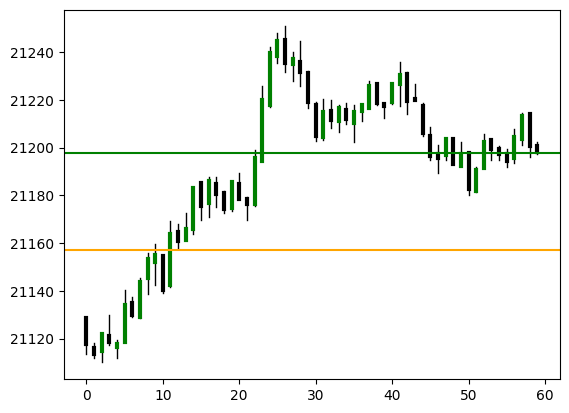

In [8]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

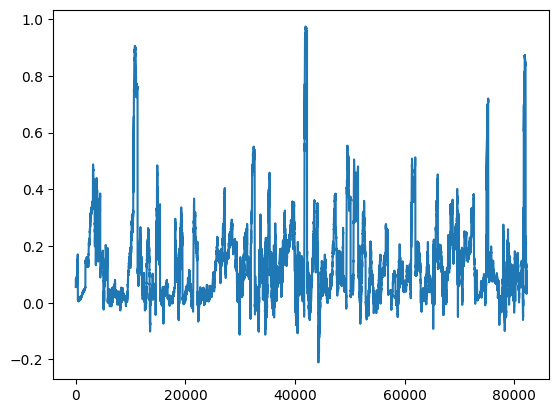

In [9]:
plt.plot(outputs)

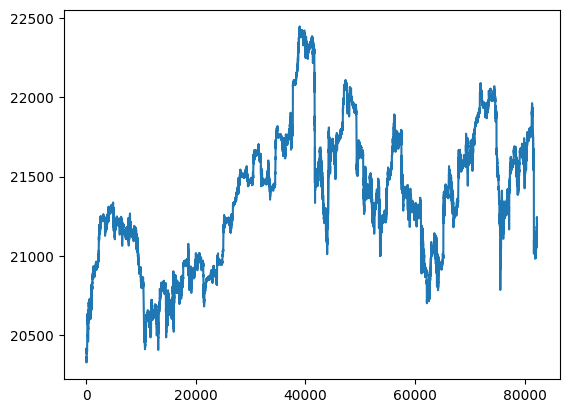

In [10]:
plt.plot([x.c for x in all_candles])

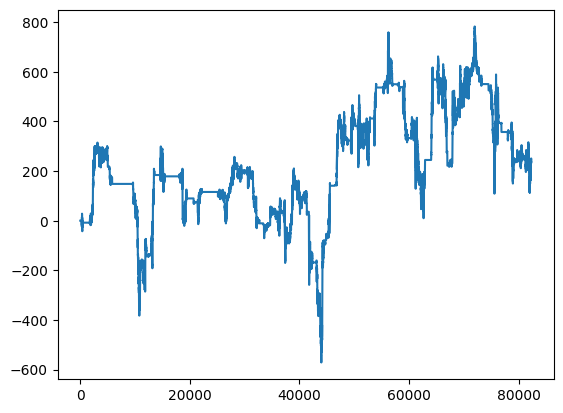

In [11]:
plt.plot(equity_L)

In [12]:
exit()